<a name="init"></a>
<h1>Machine Learning Review</h1>

#### Sobre material de [Aurelien Geron](https://github.com/ageron/handson-ml3) y [Daniel Ortiz López](https://www.linkedin.com/in/daniel-ortiz-l%C3%B3pez/)

En este notebook vamos a dar un repaso breve al **proceso extremo a extremo de Machine Learning** para generar modelos **antes de su puesta en producción**. Trataremos dos problemas de "Negocio" con técnicas de aprendizaje supervisado.



## Zoom In: Machine Learning en una imagen

<img src="./img/ml_pipeline.png" alt="drawing" width="650"/>

<img src="./img/model_review.png" alt="drawing" width="700"/>

## Zoom Out: En un contexto "real"

<img src="./img/the_big_picture.png" alt="drawing" width="800"/>

## Todo empieza con un problema (meta, deseo, etc)...

En nuestro caso, tenemos dos. Después de nuestro exitoso paso por el PT de DS en TheBridge, trabajamos en **_GresDat_** (Global Real State Data).
Nos han propuesto dos trabajos/problemas que creemos que podemos solucionar a partir de un mismo conjunto de datos:  
1- Una empresa de campos de golf: **Predecir el valor de las casas en California**, en concreto en los más de veinte mil distritos del estado.  
2- Una empresa de encuestas para campañas de publicidad: Estimar que **tipo de preferencia deportiva (NFL o NBA)** existe en esos distritos.  

NOTA: Esta es una definición todavía muy vaga, pero lo iremos viendo...

## ... y sigue con los datos

Revisando las bases de datos de GresDat encontramos un par de fuentes interesantes:  
* Los datos de precios medios establecidos por campañas anteriores en función de una serie de características
* Los datos geográficos de preferencias de NBA y NFL que se emplearon en proyectos anteriores

# Obtengamos los datos

<img src="./img/ml_pipeline_2.png" alt="drawing" width="650"/>

In [1]:
import numpy as np
import pandas as pd
import time as tm #epoch - 

In [2]:
t_zero = tm.time()

In [3]:
tm.time() - t_zero

0.005452156066894531

In [4]:
FICHERO_DATOS_GENERALES = "./data/housing_general_data_ml.csv"
FICHERO_DATOS_OTROS = "./data/housing_geof_data_ml.csv"

In [5]:
df_fuente_casa_datos_generales = pd.read_csv(FICHERO_DATOS_GENERALES)
df_fuente_casa_datos_otros = pd.read_csv(FICHERO_DATOS_OTROS)

In [6]:
df_fuente_casa_datos_generales.head()
#entener los datos, qué estoy viendo.Son distritos de California
## edad media de las casas
## total de habitaciones
## total dormitorios
## población
## nucleos familiares
## target

housing_median_age  total_rooms  total_bedrooms  population  households  \
0                41.0        880.0           129.0       322.0       126.0   
1                21.0       7099.0          1106.0      2401.0      1138.0   
2                52.0       1467.0           190.0       496.0       177.0   
3                52.0       1274.0           235.0       558.0       219.0   
4                52.0       1627.0           280.0       565.0       259.0   

   median_house_value ocean_proximity  income_cat  \
0            452600.0        NEAR BAY           5   
1            358500.0        NEAR BAY           5   
2            352100.0        NEAR BAY           5   
3            341300.0        NEAR BAY           4   
4            342200.0        NEAR BAY           3   

                              district_id  
0  0-4bba9204-92ef-4438-9ec3-2d0e8241b1fe  
1  0-da0bef30-7957-4318-8da4-f2802d20b334  
2  0-acc0dc68-6849-4670-89ee-06b5f9d056b6  
3  0-f0ce96ca-c315-4c57-822e-a1c55e0bb874  
4  0-284da5f3-e5b3-4bfc-8e42-78c418011bb4

In [7]:
df_fuente_casa_datos_otros.head()
# localización de la casa
# si le gusta NBA

longitude  latitude    NBA                           district_id
0    -120.93     39.90   True  000057c1-ba24-47e0-8be5-b86f3107a1a5
1    -117.08     32.62   True  0003be7b-8f81-43ed-a627-28e6a75a2530
2    -116.52     32.90  False  00052642-8e20-4513-828e-6b4c5c820e67
3    -117.08     33.14   True  00058840-12b0-4df5-b6ed-c8b0e6c21038
4    -118.06     33.81  False  0008d438-d4a6-4a26-9075-f0ea346f0bd3

In [8]:
df_fuente_casa_datos_generales.district_id.is_unique

True

In [9]:
# A mi me gusta más así
df_fuente_casa_datos_generales["district_id"].is_unique

True

In [10]:
df_fuente_casa_datos_otros.district_id.is_unique
#vemos que no hay repetidos

True

In [11]:
# Tenemos que crearnos nuestro dataset
housing = df_fuente_casa_datos_generales.merge(df_fuente_casa_datos_otros, on = "district_id", how = "left", indicator=True)

In [12]:
df_fuente_casa_datos_otros.iloc[:5].district_id

0    000057c1-ba24-47e0-8be5-b86f3107a1a5
1    0003be7b-8f81-43ed-a627-28e6a75a2530
2    00052642-8e20-4513-828e-6b4c5c820e67
3    00058840-12b0-4df5-b6ed-c8b0e6c21038
4    0008d438-d4a6-4a26-9075-f0ea346f0bd3
Name: district_id, dtype: object

In [13]:
df_fuente_casa_datos_otros["new_district_id"] = df_fuente_casa_datos_otros.district_id.apply(lambda row: "".join(["0-", row]))
df_fuente_casa_datos_otros["new_district_id"].head()

0    0-000057c1-ba24-47e0-8be5-b86f3107a1a5
1    0-0003be7b-8f81-43ed-a627-28e6a75a2530
2    0-00052642-8e20-4513-828e-6b4c5c820e67
3    0-00058840-12b0-4df5-b6ed-c8b0e6c21038
4    0-0008d438-d4a6-4a26-9075-f0ea346f0bd3
Name: new_district_id, dtype: object

In [14]:
df_fuente_casa_datos_otros['new_district_id'].apply(lambda x : x.replace("0-", ""))

0          000057c1-ba24-47e8be5-b86f3107a1a5
1        0003be7b-8f81-43ed-a627-28e6a75a2530
2          00052642-8e24513-828e-6b4c5c820e67
3            000588412b4df5-b6ed-c8b0e6c21038
4        0008d438-d4a6-4a26-9075-f0ea346f0bd3
                         ...                 
20635      fff6af9a389-495b-b381-73c7d383cc40
20636      fff81ef8-4434ebb-b66b-4a724b4bf869
20637    fffb7ca7-8413-4759-ab5d-9d9323a9f4b0
20638      fffe5b22-3b44-4c94-8aa775f6de8b797
20639    fffeb58a-2848-490b-bc6e-437223f6ada7
Name: new_district_id, Length: 20640, dtype: object

In [15]:
housing = df_fuente_casa_datos_generales.merge(df_fuente_casa_datos_otros, left_on ="district_id",right_on='new_district_id', how = "left", indicator=True)

In [16]:
housing

housing_median_age  total_rooms  total_bedrooms  population  \
0                    41.0        880.0           129.0       322.0   
1                    21.0       7099.0          1106.0      2401.0   
2                    52.0       1467.0           190.0       496.0   
3                    52.0       1274.0           235.0       558.0   
4                    52.0       1627.0           280.0       565.0   
...                   ...          ...             ...         ...   
20635                25.0       1665.0           374.0       845.0   
20636                18.0        697.0           150.0       356.0   
20637                17.0       2254.0           485.0      1007.0   
20638                18.0       1860.0           409.0       741.0   
20639                16.0       2785.0           616.0      1387.0   

       households  median_house_value ocean_proximity  income_cat  \
0           126.0            452600.0        NEAR BAY           5   
1          1138.0            358500.0        NEAR BAY           5   
2           177.0            352100.0        NEAR BAY           5   
3           219.0            341300.0        NEAR BAY           4   
4           259.0            342200.0        NEAR BAY           3   
...           ...                 ...             ...         ...   
20635       330.0             78100.0          INLAND           2   
20636       114.0             77100.0          INLAND           2   
20637       433.0             92300.0          INLAND           2   
20638       349.0             84700.0          INLAND           2   
20639       530.0             89400.0          INLAND           2   

                                district_id_x  longitude  latitude    NBA  \
0      0-4bba9204-92ef-4438-9ec3-2d0e8241b1fe    -122.23     37.88  False   
1      0-da0bef30-7957-4318-8da4-f2802d20b334    -122.22     37.86   True   
2      0-acc0dc68-6849-4670-89ee-06b5f9d056b6    -122.24     37.85  False   
3      0-f0ce96ca-c315-4c57-822e-a1c55e0bb874    -122.25     37.85   True   
4      0-284da5f3-e5b3-4bfc-8e42-78c418011bb4    -122.25     37.85   True   
...                                       ...        ...       ...    ...   
20635  0-a0473701-174a-4bf1-bea7-ff016246ee3f    -121.09     39.48   True   
20636  0-2fd756ea-faf5-4c8c-b894-ab7fd386eb0e    -121.21     39.49   True   
20637  0-d77d60d5-586d-4784-98a3-84dafbb2d6ec    -121.22     39.43   True   
20638  0-aef0f89c-d1db-44e0-a0b1-541759104f58    -121.32     39.43   True   
20639  0-a69a3865-6bba-4d4f-98aa-5b4040fc6333    -121.24     39.37  False   

                              district_id_y  \
0      4bba9204-92ef-4438-9ec3-2d0e8241b1fe   
1      da0bef30-7957-4318-8da4-f2802d20b334   
2      acc0dc68-6849-4670-89ee-06b5f9d056b6   
3      f0ce96ca-c315-4c57-822e-a1c55e0bb874   
4      284da5f3-e5b3-4bfc-8e42-78c418011bb4   
...                                     ...   
20635  a0473701-174a-4bf1-bea7-ff016246ee3f   
20636  2fd756ea-faf5-4c8c-b894-ab7fd386eb0e   
20637  d77d60d5-586d-4784-98a3-84dafbb2d6ec   
20638  aef0f89c-d1db-44e0-a0b1-541759104f58   
20639  a69a3865-6bba-4d4f-98aa-5b4040fc6333   

                              new_district_id _merge  
0      0-4bba9204-92ef-4438-9ec3-2d0e8241b1fe   both  
1      0-da0bef30-7957-4318-8da4-f2802d20b334   both  
2      0-acc0dc68-6849-4670-89ee-06b5f9d056b6   both  
3      0-f0ce96ca-c315-4c57-822e-a1c55e0bb874   both  
4      0-284da5f3-e5b3-4bfc-8e42-78c418011bb4   both  
...                                       ...    ...  
20635  0-a0473701-174a-4bf1-bea7-ff016246ee3f   both  
20636  0-2fd756ea-faf5-4c8c-b894-ab7fd386eb0e   both  
20637  0-d77d60d5-586d-4784-98a3-84dafbb2d6ec   both  
20638  0-aef0f89c-d1db-44e0-a0b1-541759104f58   both  
20639  0-a69a3865-6bba-4d4f-98aa-5b4040fc6333   both  

[20640 rows x 15 columns]

In [17]:
housing = df_fuente_casa_datos_generales.merge(df_fuente_casa_datos_otros, left_on ="district_id",right_on='new_district_id', how = "left", indicator=True, suffixes=["_housing", "_NBA"])

In [18]:
housing.drop(["district_id", "district_id_y"], axis=1, inplace=True, errors='ignore')

In [19]:
print(len(housing))

20640


In [20]:
housing.head()
#

housing_median_age  total_rooms  total_bedrooms  population  households  \
0                41.0        880.0           129.0       322.0       126.0   
1                21.0       7099.0          1106.0      2401.0      1138.0   
2                52.0       1467.0           190.0       496.0       177.0   
3                52.0       1274.0           235.0       558.0       219.0   
4                52.0       1627.0           280.0       565.0       259.0   

   median_house_value ocean_proximity  income_cat  \
0            452600.0        NEAR BAY           5   
1            358500.0        NEAR BAY           5   
2            352100.0        NEAR BAY           5   
3            341300.0        NEAR BAY           4   
4            342200.0        NEAR BAY           3   

                      district_id_housing  longitude  latitude    NBA  \
0  0-4bba9204-92ef-4438-9ec3-2d0e8241b1fe    -122.23     37.88  False   
1  0-da0bef30-7957-4318-8da4-f2802d20b334    -122.22     37.86   True   
2  0-acc0dc68-6849-4670-89ee-06b5f9d056b6    -122.24     37.85  False   
3  0-f0ce96ca-c315-4c57-822e-a1c55e0bb874    -122.25     37.85   True   
4  0-284da5f3-e5b3-4bfc-8e42-78c418011bb4    -122.25     37.85   True   

                        district_id_NBA  \
0  4bba9204-92ef-4438-9ec3-2d0e8241b1fe   
1  da0bef30-7957-4318-8da4-f2802d20b334   
2  acc0dc68-6849-4670-89ee-06b5f9d056b6   
3  f0ce96ca-c315-4c57-822e-a1c55e0bb874   
4  284da5f3-e5b3-4bfc-8e42-78c418011bb4   

                          new_district_id _merge  
0  0-4bba9204-92ef-4438-9ec3-2d0e8241b1fe   both  
1  0-da0bef30-7957-4318-8da4-f2802d20b334   both  
2  0-acc0dc68-6849-4670-89ee-06b5f9d056b6   both  
3  0-f0ce96ca-c315-4c57-822e-a1c55e0bb874   both  
4  0-284da5f3-e5b3-4bfc-8e42-78c418011bb4   both

In [21]:
housing.NBA.value_counts() # no ha cruzado ninguno 

NBA
True     10486
False    10154
Name: count, dtype: int64

In [22]:
# Repetir sin usar como atributo

In [23]:
# Añadir flag para clasificar el merge 
housing = df_fuente_casa_datos_generales.merge(df_fuente_casa_datos_otros, 
                                               on = "district_id", 
                                               how = "left", 
                                               indicator=True)

In [24]:
housing["_merge"].value_counts()

_merge
left_only     20640
right_only        0
both              0
Name: count, dtype: int64

#### La primera en la frente: No han cruzado bien, tendremos que ver que ha ocurrido... (tranquilos usaremos la máquina del tiempo de Arguiñano)
NOTA: Los chistes no son míos. Gabriela: contexto

In [25]:
df_fuente_casa_datos_generales.iloc[:5].district_id #acceso por índice (saca las 5 primeras filas)

0    0-4bba9204-92ef-4438-9ec3-2d0e8241b1fe
1    0-da0bef30-7957-4318-8da4-f2802d20b334
2    0-acc0dc68-6849-4670-89ee-06b5f9d056b6
3    0-f0ce96ca-c315-4c57-822e-a1c55e0bb874
4    0-284da5f3-e5b3-4bfc-8e42-78c418011bb4
Name: district_id, dtype: object

In [26]:
df_fuente_casa_datos_otros.iloc[:5].district_id

0    000057c1-ba24-47e0-8be5-b86f3107a1a5
1    0003be7b-8f81-43ed-a627-28e6a75a2530
2    00052642-8e20-4513-828e-6b4c5c820e67
3    00058840-12b0-4df5-b6ed-c8b0e6c21038
4    0008d438-d4a6-4a26-9075-f0ea346f0bd3
Name: district_id, dtype: object

Tenemos que arreglar el problema con los indices

In [27]:
df_fuente_casa_datos_otros["new_district_id"] = df_fuente_casa_datos_otros.district_id.apply(lambda row: "0-" + row)
df_fuente_casa_datos_otros["new_district_id"].head()

0    0-000057c1-ba24-47e0-8be5-b86f3107a1a5
1    0-0003be7b-8f81-43ed-a627-28e6a75a2530
2    0-00052642-8e20-4513-828e-6b4c5c820e67
3    0-00058840-12b0-4df5-b6ed-c8b0e6c21038
4    0-0008d438-d4a6-4a26-9075-f0ea346f0bd3
Name: new_district_id, dtype: object

In [28]:
# hacer con .join
df_fuente_casa_datos_otros["new_district_id"] = df_fuente_casa_datos_otros.district_id.apply(lambda row: "".join(["0-", row]))
df_fuente_casa_datos_otros["new_district_id"].head()

0    0-000057c1-ba24-47e0-8be5-b86f3107a1a5
1    0-0003be7b-8f81-43ed-a627-28e6a75a2530
2    0-00052642-8e20-4513-828e-6b4c5c820e67
3    0-00058840-12b0-4df5-b6ed-c8b0e6c21038
4    0-0008d438-d4a6-4a26-9075-f0ea346f0bd3
Name: new_district_id, dtype: object

In [29]:
# quitar 0-
df_fuente_casa_datos_otros["new_district_id"].apply(lambda x: x.replace("0-", ""))

0          000057c1-ba24-47e8be5-b86f3107a1a5
1        0003be7b-8f81-43ed-a627-28e6a75a2530
2          00052642-8e24513-828e-6b4c5c820e67
3            000588412b4df5-b6ed-c8b0e6c21038
4        0008d438-d4a6-4a26-9075-f0ea346f0bd3
                         ...                 
20635      fff6af9a389-495b-b381-73c7d383cc40
20636      fff81ef8-4434ebb-b66b-4a724b4bf869
20637    fffb7ca7-8413-4759-ab5d-9d9323a9f4b0
20638      fffe5b22-3b44-4c94-8aa775f6de8b797
20639    fffeb58a-2848-490b-bc6e-437223f6ada7
Name: new_district_id, Length: 20640, dtype: object

In [30]:
df_fuente_casa_datos_otros["new_district_id"].str.replace("0-", "")

0          000057c1-ba24-47e8be5-b86f3107a1a5
1        0003be7b-8f81-43ed-a627-28e6a75a2530
2          00052642-8e24513-828e-6b4c5c820e67
3            000588412b4df5-b6ed-c8b0e6c21038
4        0008d438-d4a6-4a26-9075-f0ea346f0bd3
                         ...                 
20635      fff6af9a389-495b-b381-73c7d383cc40
20636      fff81ef8-4434ebb-b66b-4a724b4bf869
20637    fffb7ca7-8413-4759-ab5d-9d9323a9f4b0
20638      fffe5b22-3b44-4c94-8aa775f6de8b797
20639    fffeb58a-2848-490b-bc6e-437223f6ada7
Name: new_district_id, Length: 20640, dtype: object

In [31]:
df_fuente_casa_datos_otros.iloc[:5].new_district_id

0    0-000057c1-ba24-47e0-8be5-b86f3107a1a5
1    0-0003be7b-8f81-43ed-a627-28e6a75a2530
2    0-00052642-8e20-4513-828e-6b4c5c820e67
3    0-00058840-12b0-4df5-b6ed-c8b0e6c21038
4    0-0008d438-d4a6-4a26-9075-f0ea346f0bd3
Name: new_district_id, dtype: object

In [32]:
housing = df_fuente_casa_datos_generales.merge(df_fuente_casa_datos_otros, left_on = "district_id", right_on = "new_district_id", how = "left", indicator=True)

In [33]:
# Formateo convencional
housing = df_fuente_casa_datos_generales.merge(df_fuente_casa_datos_otros,
                                               left_on = "district_id",
                                               right_on = "new_district_id",
                                               how = "left", 
                                               indicator=True)

In [34]:
housing.groupby(["_merge"])["_merge"].count()

C:\Users\pabma\AppData\Local\Temp\ipykernel_22424\3420443882.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  housing.groupby(["_merge"])["_merge"].count()


_merge
left_only         0
right_only        0
both          20640
Name: _merge, dtype: int64

In [35]:
housing.head()

housing_median_age  total_rooms  total_bedrooms  population  households  \
0                41.0        880.0           129.0       322.0       126.0   
1                21.0       7099.0          1106.0      2401.0      1138.0   
2                52.0       1467.0           190.0       496.0       177.0   
3                52.0       1274.0           235.0       558.0       219.0   
4                52.0       1627.0           280.0       565.0       259.0   

   median_house_value ocean_proximity  income_cat  \
0            452600.0        NEAR BAY           5   
1            358500.0        NEAR BAY           5   
2            352100.0        NEAR BAY           5   
3            341300.0        NEAR BAY           4   
4            342200.0        NEAR BAY           3   

                            district_id_x  longitude  latitude    NBA  \
0  0-4bba9204-92ef-4438-9ec3-2d0e8241b1fe    -122.23     37.88  False   
1  0-da0bef30-7957-4318-8da4-f2802d20b334    -122.22     37.86   True   
2  0-acc0dc68-6849-4670-89ee-06b5f9d056b6    -122.24     37.85  False   
3  0-f0ce96ca-c315-4c57-822e-a1c55e0bb874    -122.25     37.85   True   
4  0-284da5f3-e5b3-4bfc-8e42-78c418011bb4    -122.25     37.85   True   

                          district_id_y  \
0  4bba9204-92ef-4438-9ec3-2d0e8241b1fe   
1  da0bef30-7957-4318-8da4-f2802d20b334   
2  acc0dc68-6849-4670-89ee-06b5f9d056b6   
3  f0ce96ca-c315-4c57-822e-a1c55e0bb874   
4  284da5f3-e5b3-4bfc-8e42-78c418011bb4   

                          new_district_id _merge  
0  0-4bba9204-92ef-4438-9ec3-2d0e8241b1fe   both  
1  0-da0bef30-7957-4318-8da4-f2802d20b334   both  
2  0-acc0dc68-6849-4670-89ee-06b5f9d056b6   both  
3  0-f0ce96ca-c315-4c57-822e-a1c55e0bb874   both  
4  0-284da5f3-e5b3-4bfc-8e42-78c418011bb4   both

In [36]:
housing = df_fuente_casa_datos_generales.merge(df_fuente_casa_datos_otros,
                                               left_on = "district_id",
                                               right_on = "new_district_id",
                                               how = "left", 
                                               suffixes= ["_housing", "_NBA"],
                                               indicator=True)

In [37]:
housing

housing_median_age  total_rooms  total_bedrooms  population  \
0                    41.0        880.0           129.0       322.0   
1                    21.0       7099.0          1106.0      2401.0   
2                    52.0       1467.0           190.0       496.0   
3                    52.0       1274.0           235.0       558.0   
4                    52.0       1627.0           280.0       565.0   
...                   ...          ...             ...         ...   
20635                25.0       1665.0           374.0       845.0   
20636                18.0        697.0           150.0       356.0   
20637                17.0       2254.0           485.0      1007.0   
20638                18.0       1860.0           409.0       741.0   
20639                16.0       2785.0           616.0      1387.0   

       households  median_house_value ocean_proximity  income_cat  \
0           126.0            452600.0        NEAR BAY           5   
1          1138.0            358500.0        NEAR BAY           5   
2           177.0            352100.0        NEAR BAY           5   
3           219.0            341300.0        NEAR BAY           4   
4           259.0            342200.0        NEAR BAY           3   
...           ...                 ...             ...         ...   
20635       330.0             78100.0          INLAND           2   
20636       114.0             77100.0          INLAND           2   
20637       433.0             92300.0          INLAND           2   
20638       349.0             84700.0          INLAND           2   
20639       530.0             89400.0          INLAND           2   

                          district_id_housing  longitude  latitude    NBA  \
0      0-4bba9204-92ef-4438-9ec3-2d0e8241b1fe    -122.23     37.88  False   
1      0-da0bef30-7957-4318-8da4-f2802d20b334    -122.22     37.86   True   
2      0-acc0dc68-6849-4670-89ee-06b5f9d056b6    -122.24     37.85  False   
3      0-f0ce96ca-c315-4c57-822e-a1c55e0bb874    -122.25     37.85   True   
4      0-284da5f3-e5b3-4bfc-8e42-78c418011bb4    -122.25     37.85   True   
...                                       ...        ...       ...    ...   
20635  0-a0473701-174a-4bf1-bea7-ff016246ee3f    -121.09     39.48   True   
20636  0-2fd756ea-faf5-4c8c-b894-ab7fd386eb0e    -121.21     39.49   True   
20637  0-d77d60d5-586d-4784-98a3-84dafbb2d6ec    -121.22     39.43   True   
20638  0-aef0f89c-d1db-44e0-a0b1-541759104f58    -121.32     39.43   True   
20639  0-a69a3865-6bba-4d4f-98aa-5b4040fc6333    -121.24     39.37  False   

                            district_id_NBA  \
0      4bba9204-92ef-4438-9ec3-2d0e8241b1fe   
1      da0bef30-7957-4318-8da4-f2802d20b334   
2      acc0dc68-6849-4670-89ee-06b5f9d056b6   
3      f0ce96ca-c315-4c57-822e-a1c55e0bb874   
4      284da5f3-e5b3-4bfc-8e42-78c418011bb4   
...                                     ...   
20635  a0473701-174a-4bf1-bea7-ff016246ee3f   
20636  2fd756ea-faf5-4c8c-b894-ab7fd386eb0e   
20637  d77d60d5-586d-4784-98a3-84dafbb2d6ec   
20638  aef0f89c-d1db-44e0-a0b1-541759104f58   
20639  a69a3865-6bba-4d4f-98aa-5b4040fc6333   

                              new_district_id _merge  
0      0-4bba9204-92ef-4438-9ec3-2d0e8241b1fe   both  
1      0-da0bef30-7957-4318-8da4-f2802d20b334   both  
2      0-acc0dc68-6849-4670-89ee-06b5f9d056b6   both  
3      0-f0ce96ca-c315-4c57-822e-a1c55e0bb874   both  
4      0-284da5f3-e5b3-4bfc-8e42-78c418011bb4   both  
...                                       ...    ...  
20635  0-a0473701-174a-4bf1-bea7-ff016246ee3f   both  
20636  0-2fd756ea-faf5-4c8c-b894-ab7fd386eb0e   both  
20637  0-d77d60d5-586d-4784-98a3-84dafbb2d6ec   both  
20638  0-aef0f89c-d1db-44e0-a0b1-541759104f58   both  
20639  0-a69a3865-6bba-4d4f-98aa-5b4040fc6333   both  

[20640 rows x 15 columns]

In [38]:
# Como evitabamos esto?
housing.drop(["district_id_x","district_id_y"], axis = 1, inplace = True, errors="ignore")
housing.drop(["district_id_housing","district_id_NBA", "_merge"], axis = 1, inplace = True, errors="ignore")

In [39]:
housing.columns

Index(['housing_median_age', 'total_rooms', 'total_bedrooms', 'population',
       'households', 'median_house_value', 'ocean_proximity', 'income_cat',
       'longitude', 'latitude', 'NBA', 'new_district_id'],
      dtype='object')

Antes de ponernos a programar tenemos que entender muy bién cuál es la problemática y de qué datos disponemos, ya que este momento puede ser un punto de inflexión importante. Quizá con un pequeño análisis previo nos demos cuenta de que no hace falta un modelo de machine learning para solventar nuestro problema, o que no tenemos sufientes datos para realizar las predicciones planteadas inicialmente.


# Hora de entender un poco mejor la estructura y los datos

<img src="./img/ml_pipeline_3.png" alt="drawing" width="700"/>

In [40]:
housing.head()

housing_median_age  total_rooms  total_bedrooms  population  households  \
0                41.0        880.0           129.0       322.0       126.0   
1                21.0       7099.0          1106.0      2401.0      1138.0   
2                52.0       1467.0           190.0       496.0       177.0   
3                52.0       1274.0           235.0       558.0       219.0   
4                52.0       1627.0           280.0       565.0       259.0   

   median_house_value ocean_proximity  income_cat  longitude  latitude    NBA  \
0            452600.0        NEAR BAY           5    -122.23     37.88  False   
1            358500.0        NEAR BAY           5    -122.22     37.86   True   
2            352100.0        NEAR BAY           5    -122.24     37.85  False   
3            341300.0        NEAR BAY           4    -122.25     37.85   True   
4            342200.0        NEAR BAY           3    -122.25     37.85   True   

                          new_district_id  
0  0-4bba9204-92ef-4438-9ec3-2d0e8241b1fe  
1  0-da0bef30-7957-4318-8da4-f2802d20b334  
2  0-acc0dc68-6849-4670-89ee-06b5f9d056b6  
3  0-f0ce96ca-c315-4c57-822e-a1c55e0bb874  
4  0-284da5f3-e5b3-4bfc-8e42-78c418011bb4

In [41]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   housing_median_age  20640 non-null  float64
 1   total_rooms         20640 non-null  float64
 2   total_bedrooms      20433 non-null  float64
 3   population          20640 non-null  float64
 4   households          20640 non-null  float64
 5   median_house_value  20640 non-null  float64
 6   ocean_proximity     20640 non-null  object 
 7   income_cat          20640 non-null  int64  
 8   longitude           20640 non-null  float64
 9   latitude            20640 non-null  float64
 10  NBA                 20640 non-null  bool   
 11  new_district_id     20640 non-null  object 
dtypes: bool(1), float64(8), int64(1), object(2)
memory usage: 1.8+ MB


In [42]:
housing.describe(include='all').T

count unique                                     top  \
housing_median_age  20640.0    NaN                                     NaN   
total_rooms         20640.0    NaN                                     NaN   
total_bedrooms      20433.0    NaN                                     NaN   
population          20640.0    NaN                                     NaN   
households          20640.0    NaN                                     NaN   
median_house_value  20640.0    NaN                                     NaN   
ocean_proximity       20640      5                               <1H OCEAN   
income_cat          20640.0    NaN                                     NaN   
longitude           20640.0    NaN                                     NaN   
latitude            20640.0    NaN                                     NaN   
NBA                   20640      2                                    True   
new_district_id       20640  20640  0-4bba9204-92ef-4438-9ec3-2d0e8241b1fe   

                     freq           mean            std      min       25%  \
housing_median_age    NaN      28.639486      12.585558      1.0      18.0   
total_rooms           NaN    2635.763081    2181.615252      2.0   1447.75   
total_bedrooms        NaN     537.870553      421.38507      1.0     296.0   
population            NaN    1425.476744    1132.462122      3.0     787.0   
households            NaN      499.53968     382.329753      1.0     280.0   
median_house_value    NaN  206855.816909  115395.615874  14999.0  119600.0   
ocean_proximity      9136            NaN            NaN      NaN       NaN   
income_cat            NaN       3.006686       1.054618      1.0       2.0   
longitude             NaN    -119.569704       2.003532  -124.35    -121.8   
latitude              NaN      35.631861       2.135952    32.54     33.93   
NBA                 10486            NaN            NaN      NaN       NaN   
new_district_id         1            NaN            NaN      NaN       NaN   

                         50%       75%       max  
housing_median_age      29.0      37.0      52.0  
total_rooms           2127.0    3148.0   39320.0  
total_bedrooms         435.0     647.0    6445.0  
population            1166.0    1725.0   35682.0  
households             409.0     605.0    6082.0  
median_house_value  179700.0  264725.0  500001.0  
ocean_proximity          NaN       NaN       NaN  
income_cat               3.0       4.0       5.0  
longitude            -118.49   -118.01   -114.31  
latitude               34.26     37.71     41.95  
NBA                      NaN       NaN       NaN  
new_district_id          NaN       NaN       NaN

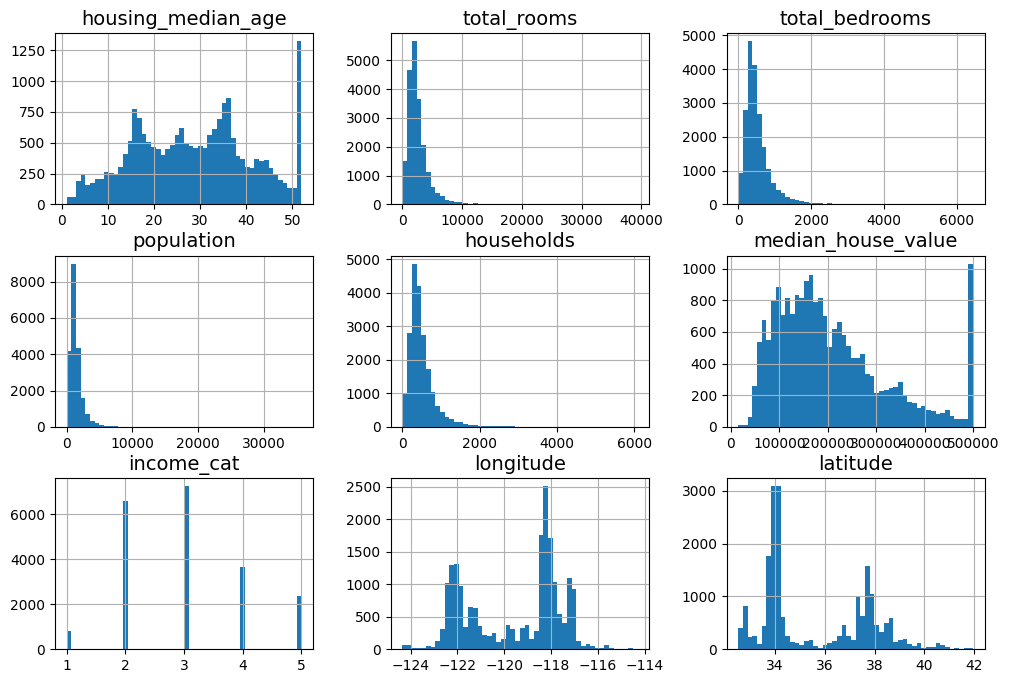

In [43]:
import matplotlib.pyplot as plt

# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins=50, figsize=(12, 8))
#save_fig("attribute_histogram_plots")  # extra code
plt.show()

In [44]:
housing.NBA.value_counts(normalize = True) #vemos cómo de balanceados están los targets (en este caso con la NBA)

NBA
True     0.508043
False    0.491957
Name: proportion, dtype: float64

## A la vista de los datos, ¿podemos decir algo sobre el tipo de problema "técnico" o aproximación que vamos a realizar en cada caso?

Es MUY IMPORTANTE conocer el tipo de problema de Machine Learning porque va a ser determinante para toda la analítica que viene a continuación

# Problema Machine Learning


<img src="./img/ml_types.png" alt="drawing" width="650"/>

#### Algoritmos supervisados
Tenemos los datos etiquetados
1. **Clasificación**: el target del problema es un conjunto de valores discretos. Dos opciones:
    - Binaria: paga/no paga, fuga de cliente/no fuga, contrae enfermedad/no contrae
    - Multiclase: clasificar fruta (manzanas, peras, naranjas...), vinos (tinto, blanco, rosado)
2. **Regresión**: el objetivo es predecir una variable continua como: distancia, temperatura, ingresos.

#### Algoritmos no supervisados
Los datos no están etiquetados. Es el propio algoritmo el que detecta patrones en los datos y los separa.
1. **Clustering**: separación automática en grupos, como por ejemplo segmentación de clientes
2. **Detección de anomalías**: fraude

Dentro de la clasificación anterior tendríamos los casos especiales de regresión con series temporales, o clasificación de imágenes/video con redes neuronales.

 # Ahora sí, empezamos a "trabajar": Preprocesado

<img src="./img/ml_pipeline_4.png" alt="drawing" width="700"/>

## Creamos un set de test y uno de training: La generalización

In [45]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [46]:
#train_set, test_set, y_train, y_test = train_test_split(housing.drop("median_house_value", axis=1), housing["median_house_value"],test_size=0.2, random_state=42)

In [47]:
print("Num_registros Train",len(train_set))
print("Num_registros Test", len(test_set))

Num_registros Train 16512
Num_registros Test 4128


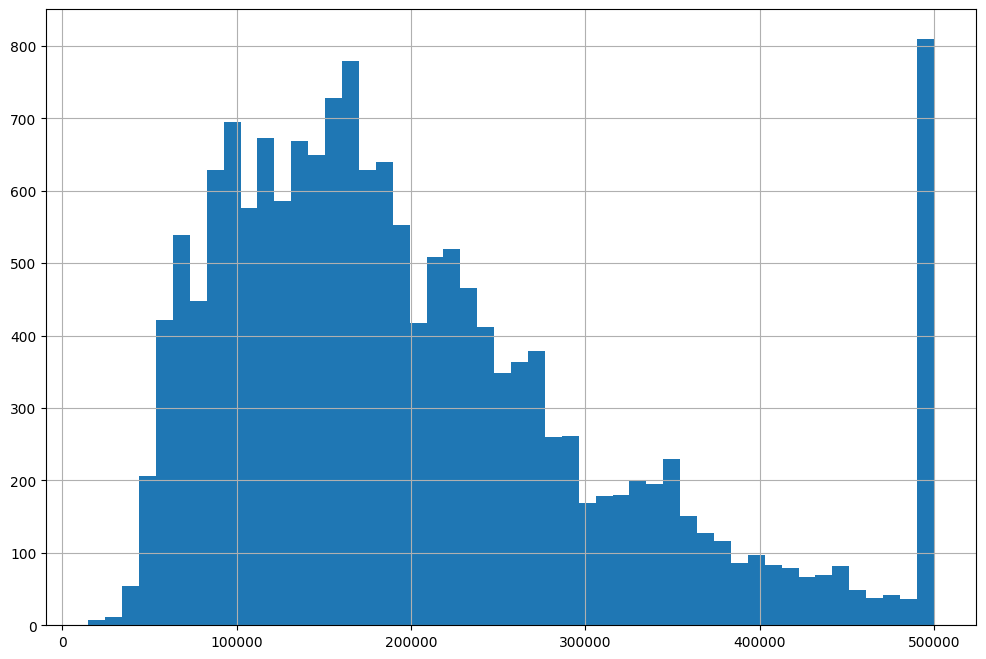

In [48]:
#ver distribución del target
plt.xlabel = "median_house_value"
train_set.median_house_value.hist(bins=50, figsize=(12, 8));

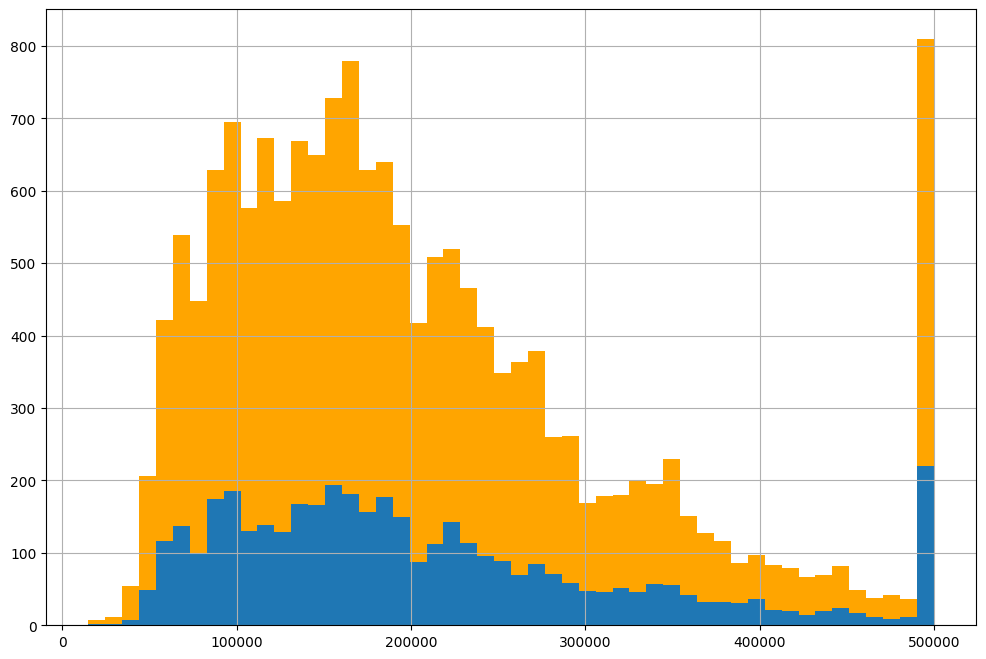

In [49]:
#distribución del target
train_set.median_house_value.hist(bins=50, figsize=(12, 8), color="orange");
test_set.median_house_value.hist(bins=50, figsize=(12, 8));


In [50]:
train_set.NBA.value_counts(dropna = False, normalize = True)

NBA
True     0.50751
False    0.49249
Name: proportion, dtype: float64

In [51]:
test_set.NBA.value_counts(dropna = False,normalize = True)

NBA
True     0.510174
False    0.489826
Name: proportion, dtype: float64

# ¿Está bien repartido por income?

In [52]:
train_set["income_cat"].value_counts(dropna = False,normalize = True)

income_cat
3    0.351926
2    0.321705
4    0.174358
5    0.112827
1    0.039184
Name: proportion, dtype: float64

In [53]:
test_set["income_cat"].value_counts(dropna = False,normalize = True)

income_cat
3    0.345203
2    0.307413
4    0.184109
5    0.120882
1    0.042393
Name: proportion, dtype: float64

Otra forma de hacer la estratificación

In [54]:
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [55]:
strat_train_set["income_cat"].value_counts(dropna = False,normalize = True)

income_cat
3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: proportion, dtype: float64

In [56]:
strat_test_set["income_cat"].value_counts(dropna = False,normalize = True)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: proportion, dtype: float64

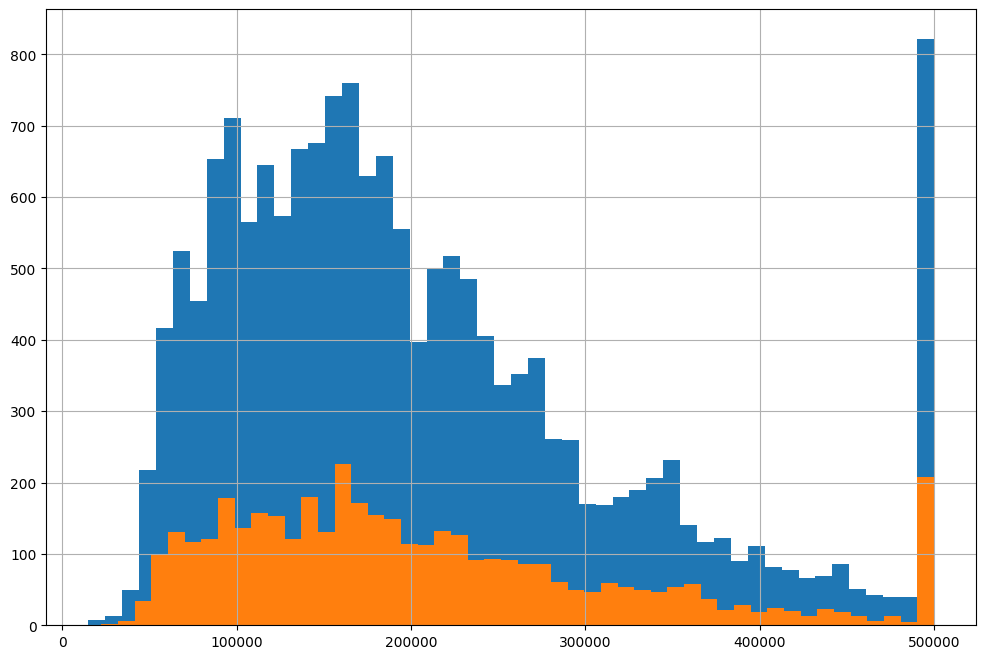

In [57]:
#ver distribución en train y test
plt.xlabel = "median_house_value"
strat_train_set.median_house_value.hist(bins=50, figsize=(12, 8))
strat_test_set.median_house_value.hist(bins=50, figsize=(12, 8));

In [58]:
strat_train_set.NBA.value_counts(normalize = True)

NBA
True     0.505572
False    0.494428
Name: proportion, dtype: float64

In [59]:
strat_test_set.NBA.value_counts(normalize = True)

NBA
True     0.517926
False    0.482074
Name: proportion, dtype: float64

In [60]:
y_train_value = strat_train_set["median_house_value"].copy()

In [61]:
y_test_value = strat_test_set["median_house_value"].copy()

In [62]:
# Alternativas?
y_train_NBA = strat_train_set.NBA.apply(lambda row: 1 if row else 0)
y_test_NBA = strat_test_set.NBA.apply(lambda row: 1 if row else 0)

In [63]:
strat_train_set.NBA.astype(int)

13096    0
14973    0
3785     1
14689    1
20507    1
        ..
14207    0
13105    1
19301    1
19121    0
19888    0
Name: NBA, Length: 16512, dtype: int32

In [64]:
strat_train_set.NBA+0

13096    0
14973    0
3785     1
14689    1
20507    1
        ..
14207    0
13105    1
19301    1
19121    0
19888    0
Name: NBA, Length: 16512, dtype: int32

## Limpieza y adaptación de los datos existentes

NOTA: Cada maestrillo tiene su librillo y puede seguir un orden diferente en los siguientes pasos hasta empezar a testar modelos. Hay quien prefiere seleccionar y/o crear features adicionales primero, y luego prepararlas, etc. 

El objetivo es definir todos los procesos de transformación y luego seguir el mismo orden con los datos de test, y en producción con los datos reales.

### Valores incompletos

In [65]:
housing_train = strat_train_set.drop(["median_house_value","NBA"], axis=1)


In [66]:
# otra forma de hacerlo?
housing_train = strat_train_set.drop(columns=["median_house_value","NBA"], errors="ignore")

### PREGUNTÓN: ¿Por qué no metemos NBA en los datos para el modelo de regresión y median_house_value en el de categorización?

In [68]:
housing_train.describe(include="all")

housing_median_age   total_rooms  total_bedrooms    population  \
count         16512.000000  16512.000000    16344.000000  16512.000000   
unique                 NaN           NaN             NaN           NaN   
top                    NaN           NaN             NaN           NaN   
freq                   NaN           NaN             NaN           NaN   
mean             28.577156   2639.402798      538.949094   1425.513929   
std              12.585738   2185.287466      423.862079   1094.795467   
min               1.000000      2.000000        1.000000      3.000000   
25%              18.000000   1447.000000      296.000000    787.000000   
50%              29.000000   2125.000000      434.000000   1167.000000   
75%              37.000000   3154.000000      645.000000   1726.000000   
max              52.000000  39320.000000     6210.000000  16305.000000   

          households ocean_proximity    income_cat     longitude  \
count   16512.000000           16512  16512.000000  16512.000000   
unique           NaN               5           NaN           NaN   
top              NaN       <1H OCEAN           NaN           NaN   
freq             NaN            7274           NaN           NaN   
mean      499.990189             NaN      3.006783   -119.573125   
std       382.865787             NaN      1.054600      2.000624   
min         1.000000             NaN      1.000000   -124.350000   
25%       279.000000             NaN      2.000000   -121.800000   
50%       408.000000             NaN      3.000000   -118.510000   
75%       603.000000             NaN      4.000000   -118.010000   
max      5358.000000             NaN      5.000000   -114.490000   

            latitude                         new_district_id  
count   16512.000000                                   16512  
unique           NaN                                   16512  
top              NaN  0-b8dea43d-5d6f-4e49-b71d-e2f10e5a5109  
freq             NaN                                       1  
mean       35.637746                                     NaN  
std         2.133294                                     NaN  
min        32.550000                                     NaN  
25%        33.930000                                     NaN  
50%        34.260000                                     NaN  
75%        37.720000                                     NaN  
max        41.950000                                     NaN

NOTA: Existen varias opciones para tratar las features incompletas:  
* Descartar las instancias
* Descartar la feature
* Imputarles un valor (media, mediana, etc)

In [69]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [70]:
total_bedrooms_null_idx = housing_train.isnull().any(axis=1)
housing_train[total_bedrooms_null_idx].total_bedrooms.value_counts(dropna = False)

total_bedrooms
NaN    168
Name: count, dtype: int64

In [72]:
# Otra forma de hacerlo
housing_train.isnull().sum()

housing_median_age      0
total_rooms             0
total_bedrooms        168
population              0
households              0
ocean_proximity         0
income_cat              0
longitude               0
latitude                0
new_district_id         0
dtype: int64

In [73]:
housing_num = housing_train.select_dtypes(include=[np.number])
# fit vs transform vs fit_transform
X = imputer.fit_transform(housing_num)

In [75]:
imputer.fit(housing_num)
X = imputer.transform(housing_num)

In [76]:
X

array([[ 5.2000e+01,  3.3210e+03,  1.1150e+03, ...,  2.0000e+00,
        -1.2242e+02,  3.7800e+01],
       [ 4.0000e+01,  1.9650e+03,  3.5400e+02, ...,  5.0000e+00,
        -1.1838e+02,  3.4140e+01],
       [ 3.3000e+01,  1.0830e+03,  2.1700e+02, ...,  2.0000e+00,
        -1.2198e+02,  3.8360e+01],
       ...,
       [ 1.3000e+01,  3.9200e+03,  7.7500e+02, ...,  3.0000e+00,
        -1.1706e+02,  3.2590e+01],
       [ 3.7000e+01,  3.7810e+03,  8.7300e+02, ...,  3.0000e+00,
        -1.1840e+02,  3.4060e+01],
       [ 4.4000e+01,  4.3100e+02,  1.9500e+02, ...,  3.0000e+00,
        -1.2241e+02,  3.7660e+01]])

In [77]:
housing_transformed = pd.DataFrame(X, columns=housing_num.columns)

In [78]:
housing_transformed.isnull().sum()

housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
income_cat            0
longitude             0
latitude              0
dtype: int64

In [74]:
imputer.statistics_

array([  29.  , 2125.  ,  434.  , 1167.  ,  408.  ,    3.  , -118.51,
         34.26])

In [79]:
imputer.feature_names_in_

array(['housing_median_age', 'total_rooms', 'total_bedrooms',
       'population', 'households', 'income_cat', 'longitude', 'latitude'],
      dtype=object)

In [80]:
# Replicar statistics_
housing_num.median()

housing_median_age      29.00
total_rooms           2125.00
total_bedrooms         434.00
population            1167.00
households             408.00
income_cat               3.00
longitude             -118.51
latitude                34.26
dtype: float64

In [81]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [82]:
housing_tr[total_bedrooms_null_idx]

housing_median_age  total_rooms  total_bedrooms  population  \
14452                15.0       5343.0           434.0      2503.0   
18217                35.0       2093.0           434.0      1755.0   
11889                33.0       1348.0           434.0      1098.0   
20325                15.0       4260.0           434.0      1701.0   
14360                 8.0       1266.0           434.0       375.0   
...                   ...          ...             ...         ...   
2348                 14.0       2313.0           434.0       954.0   
366                  44.0       1819.0           434.0      1137.0   
18241                39.0       2855.0           434.0      1217.0   
18493                22.0        894.0           434.0       830.0   
16519                16.0       4632.0           434.0      3038.0   

       households  income_cat  longitude  latitude  
14452       902.0         3.0    -120.67     40.50  
18217       403.0         3.0    -117.96     34.03  
11889       257.0         3.0    -118.05     34.04  
20325       669.0         4.0    -118.88     34.17  
14360       183.0         5.0    -117.87     33.62  
...           ...         ...        ...       ...  
2348        397.0         3.0    -122.70     38.35  
366         354.0         3.0    -122.50     37.75  
18241       562.0         3.0    -121.44     38.54  
18493       202.0         3.0    -116.21     33.75  
16519       727.0         4.0    -117.86     34.01  

[168 rows x 8 columns]

In [84]:
# Hacerlo con imputer y add indicator
imputer_2 = SimpleImputer(strategy='median')

Como en los cursos de cocina, hemos probado el imputer, nos gusta y lo dejamos ahí preparadito para al final juntarlo todo

### REVISIÓN PIPELINES
Un pipeline es como una receta de pasos. Es un "workflow". El último paso es fit.  
Básicamente es una forma de ahorrar código, de hacernos la vida más fácil. 

Esto nos permite importar todos los pasos sin tener que "hacer" el código de nuevo. 


In [85]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [86]:
list_transformers = [("imputador", SimpleImputer(strategy = "median")), ("escalador", StandardScaler())]
pipe_prueba = Pipeline(list_transformers)

In [87]:
housing_tr = pipe_prueba.fit_transform(housing_num)

In [89]:
housing_tr_ = pd.DataFrame(housing_tr, columns=housing_num.columns)
housing_tr_

housing_median_age  total_rooms  total_bedrooms  population  \
0                1.861119     0.311912        1.368167    0.137460   
1                0.907630    -0.308620       -0.435925   -0.693771   
2                0.351428    -0.712240       -0.760709   -0.788768   
3               -0.919891     0.702262        0.742306    0.383175   
4                0.589800     0.790125        1.595753    0.444376   
...                   ...          ...             ...         ...   
16507            0.987087    -0.184147        0.140152   -0.445315   
16508           -0.443146     0.139847        0.128298   -0.005950   
16509           -1.237721     0.586026        0.562134    1.268299   
16510            0.669257     0.522417        0.794461    0.273563   
16511            1.225459    -1.010608       -0.812864   -0.679156   

       households  income_cat  longitude  latitude  
0        1.394812   -0.954687  -1.423037  1.013606  
1       -0.373485    1.890078   0.596394 -0.702103  
2       -0.775727   -0.954687  -1.203098  1.276119  
3        0.731375   -0.954687   1.231216 -0.884924  
4        1.755263   -0.006432   0.711362 -0.875549  
...           ...         ...        ...       ...  
16507    0.060101    0.941823   0.586397 -0.833359  
16508    0.083608   -0.954687   0.131525  0.319822  
16509    0.679135   -0.006432   1.256209 -1.428701  
16510    0.882868   -0.006432   0.586397 -0.739605  
16511   -0.752219   -0.006432  -1.418038  0.947978  

[16512 rows x 8 columns]

In [90]:
pipe_prueba['imputador'].statistics_

array([  29.  , 2125.  ,  434.  , 1167.  ,  408.  ,    3.  , -118.51,
         34.26])

In [91]:
pipe_prueba['escalador'].mean_

array([  28.57715601, 2639.40279797,  537.88129845, 1425.51392926,
        499.99018895,    3.00678295, -119.573125  ,   35.63774649])

### Categóricas y Texto

NOTA: No siempre tendremos que "convertir" las categóricas y las textuales, pero no es mala práctica porque en general en DL siempre haremos algún tipo de conversión-encoding

Tenemos que tratar... ocean_proximity

¿Merece la pena?

In [92]:
housing_graph = strat_train_set.copy()

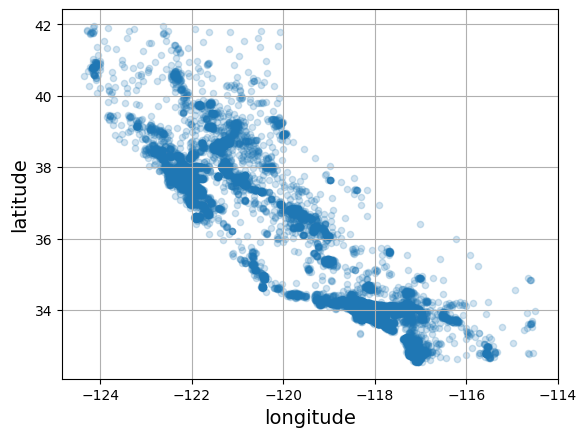

In [93]:
housing_graph.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.show()

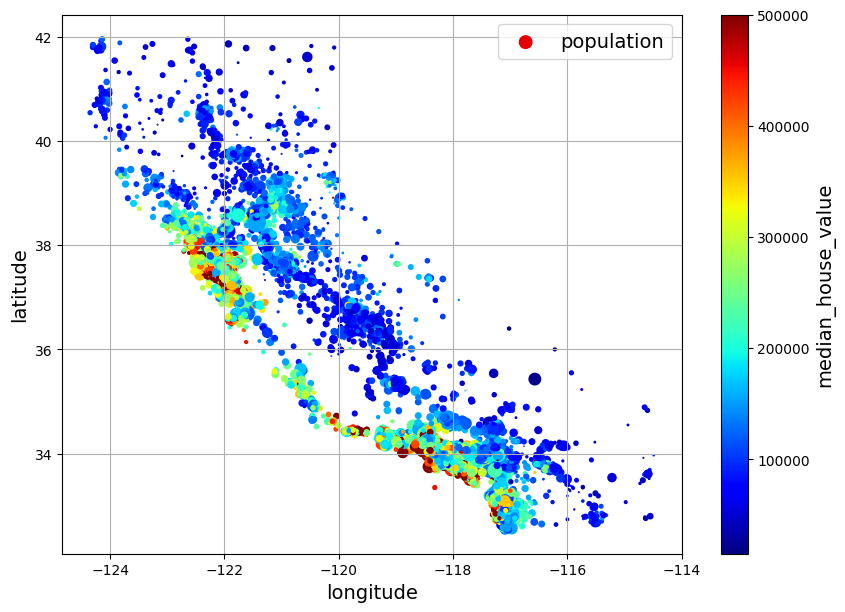

In [94]:
housing_graph.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing_graph["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
plt.show()

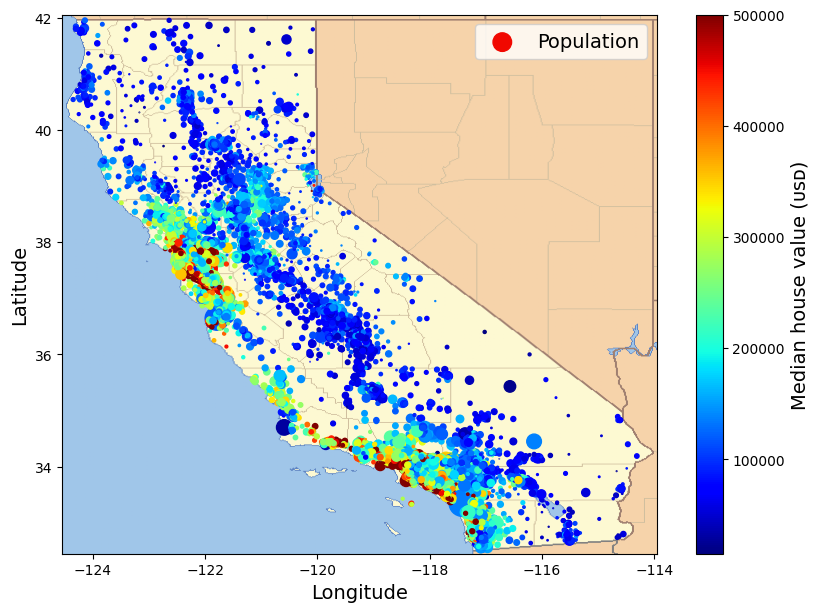

In [95]:
# SOLO POR SI ALGUIEN NO LO VE
# extra code – this cell generates the first figure in the chapter

# Download the California image
import urllib.request
from pathlib import Path
IMAGES_PATH = Path() / "img"
filename = "california.png"
homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
url = homl3_root + "images/end_to_end_project/" + filename
print("Downloading", filename)
urllib.request.urlretrieve(url, IMAGES_PATH / filename)

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed.plot(
             kind="scatter", x="Longitude", y="Latitude",
             s=housing_renamed["Population"] / 100, label="Population",
             c="Median house value (ᴜsᴅ)", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

california_img = plt.imread(IMAGES_PATH / filename)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)
plt.show()

In [96]:
housing_cat = housing_train[["ocean_proximity"]]
housing_cat.head(8)

ocean_proximity
13096        NEAR BAY
14973       <1H OCEAN
3785           INLAND
14689          INLAND
20507      NEAR OCEAN
1286           INLAND
18078       <1H OCEAN
4396         NEAR BAY

In [98]:
#Lo mismo que get_dummies de pd pero trabaja con arrays de numpy
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [101]:
# OneHotEndoder vs OrdinalHotEncoder
from sklearn.preprocessing import OrdinalEncoder

cat_ord_encoder = OrdinalEncoder()
housing_cat_ord = cat_ord_encoder.fit_transform(housing_cat)

In [99]:
housing_cat_1hot

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [100]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [102]:
cat_encoder = OneHotEncoder(sparse_output=False)
df_housing_cat_1hot = pd.DataFrame(cat_encoder.fit_transform(housing_cat), columns= cat_encoder.get_feature_names_out())

In [103]:
df_housing_cat_1hot.head(8)

ocean_proximity_<1H OCEAN  ocean_proximity_INLAND  ocean_proximity_ISLAND  \
0                        0.0                     0.0                     0.0   
1                        1.0                     0.0                     0.0   
2                        0.0                     1.0                     0.0   
3                        0.0                     1.0                     0.0   
4                        0.0                     0.0                     0.0   
5                        0.0                     1.0                     0.0   
6                        1.0                     0.0                     0.0   
7                        0.0                     0.0                     0.0   

   ocean_proximity_NEAR BAY  ocean_proximity_NEAR OCEAN  
0                       1.0                         0.0  
1                       0.0                         0.0  
2                       0.0                         0.0  
3                       0.0                         0.0  
4                       0.0                         1.0  
5                       0.0                         0.0  
6                       0.0                         0.0  
7                       1.0                         0.0

In [104]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [105]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [106]:
housing_cat_1hot

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

# Selección de Features y generación de features

### Reducción de Features

En ocasiones es casi imposible llevar a cabo un análisis exploratorio si tienes una gran cantidad de features. Si ese es tu caso, deberías seguir alguna de las recomendaciones de este apartado.

Básicamente lo que haremos es eliminar algunas features. ¿Qué criterios seguiremos?

    Muchos missings: a partir de un 40% de missings ya son features casi insalvables
    Features repetidas: columnas repetidas. Asegúrate bien de que sea así.
    Identificadores: ids, nombres únicos. Son features que no aportan nada

    Feature selection

    4.1 Correlación lineal: coeficientes de Pearson entre [-0.1, +0.1] respecto a nuestro target, suelen ser variables que no tiene nada que ver con el mismo.

    4.2 Feature importance: podemos tirar un modelo rápidamente que nos de la importancia de cada feature respecto al target: RandomForest se suele usar.

    4.3 Varianza: variables que no tienen varianza no nos interesan. El caso extremo sería una constante. No nos aporta nada. Es útil para ver que las variables pueden servir para el modelo pero no nos da una relación con el target.

    4.4 Estadísticos: la función de sklearn SelectKBest permite aplicar un test estadístico entre el target y cada uno de las features para determinar qué variables están relacionadas.

En este momento lo que se pretende es eliminar features que sabes con certeza que son muy inútiles, por lo que los criterios para eliminar features en este punto del análisis serán mucho menos restrictivos que en posteriores (no queremos cargarnos información sin conocer bien el dataset).

De momento, será suficiente con seguir los puntos 1, 2 y 3. El punto 4 se aplicarán si la cantidad de features es muy grande, por ejemplo más de 50 features.

In [107]:
corr_matrix = strat_train_set.select_dtypes(include=[np.number]).corr()

In [108]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
income_cat            0.642887
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

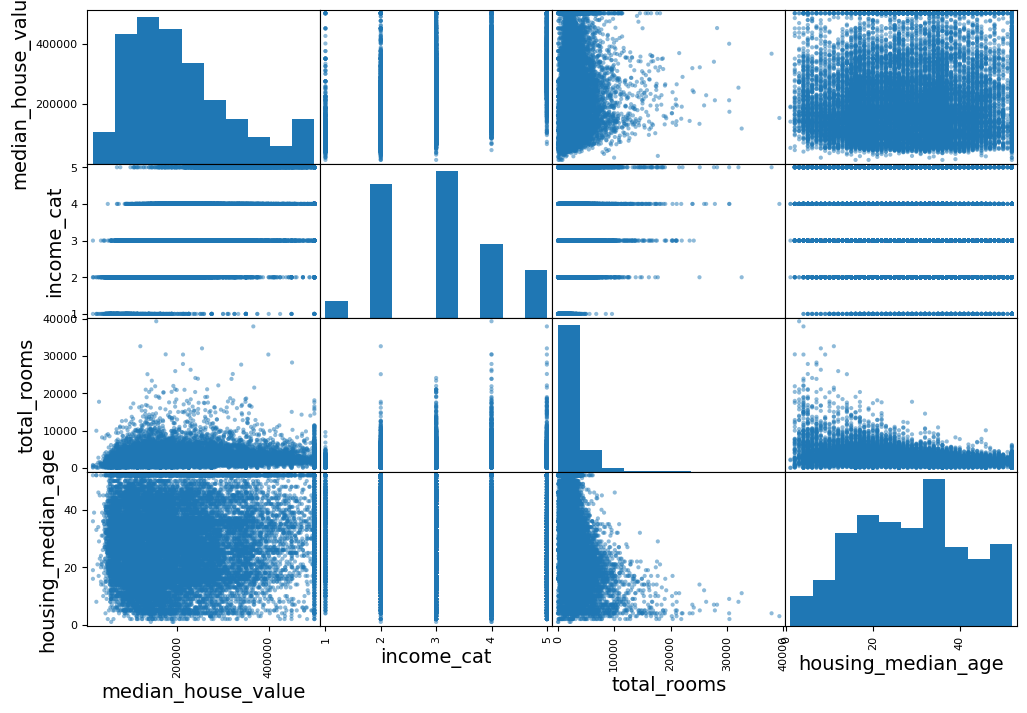

In [109]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "income_cat", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
#save_fig("scatter_matrix_plot")  # extra code
plt.show()

### Creación de nuevas features

In [110]:
housing_new_features = strat_train_set.copy()

In [111]:
housing_new_features["rooms_per_house"] = housing_new_features["total_rooms"] / housing_new_features["households"]
housing_new_features["bedrooms_ratio"] = housing_new_features["total_bedrooms"] / housing_new_features["total_rooms"]
housing_new_features["people_per_house"] = housing_new_features["population"] / housing_new_features["households"]

In [112]:
corr_matrix = housing_new_features.select_dtypes(include=[np.number]).corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
income_cat            0.642887
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

¿Alguna que merezca la pena?

De nuevo, lo dejamos aparte "en la mesa" para luego meter todos los procesados en un pipeline y así poder sistematizar su aplicación

Ya casi estamos a puntito de cocinar...

<img src="./img/ml_pipeline_5.png" alt="drawing" width="700"/>

### Escalado y transformacion de Features

In [113]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

In [114]:
housing_num.head(8)

housing_median_age  total_rooms  total_bedrooms  population  \
13096                52.0       3321.0          1115.0      1576.0   
14973                40.0       1965.0           354.0       666.0   
3785                 33.0       1083.0           217.0       562.0   
14689                17.0       4174.0           851.0      1845.0   
20507                36.0       4366.0          1211.0      1912.0   
1286                 52.0       1829.0           301.0       694.0   
18078                34.0       1086.0           197.0       509.0   
4396                 36.0       4787.0           900.0      2039.0   

       households  income_cat  longitude  latitude  
13096      1034.0           2    -122.42     37.80  
14973       357.0           5    -118.38     34.14  
3785        203.0           2    -121.98     38.36  
14689       780.0           2    -117.11     33.75  
20507      1172.0           3    -118.15     33.77  
1286        319.0           3    -121.31     37.96  
18078       158.0           5    -118.36     33.85  
4396        890.0           4    -122.13     37.41

In [115]:
pd.DataFrame(housing_num_std_scaled, columns = housing_num.columns).head(8)

housing_median_age  total_rooms  total_bedrooms  population  households  \
0            1.861119     0.311912        1.359094    0.137460    1.394812   
1            0.907630    -0.308620       -0.436356   -0.693771   -0.373485   
2            0.351428    -0.712240       -0.759584   -0.788768   -0.775727   
3           -0.919891     0.702262        0.736231    0.383175    0.731375   
4            0.589800     0.790125        1.585590    0.444376    1.755263   
5            1.861119    -0.370856       -0.561400   -0.668194   -0.472739   
6            0.430885    -0.710868       -0.806771   -0.837181   -0.893265   
7            0.589800     0.982782        0.851838    0.560383    1.018690   

   income_cat  longitude  latitude  
0   -0.954687  -1.423037  1.013606  
1    1.890078   0.596394 -0.702103  
2   -0.954687  -1.203098  1.276119  
3   -0.954687   1.231216 -0.884924  
4   -0.006432   0.711362 -0.875549  
5   -0.006432  -0.868193  1.088610  
6    1.890078   0.606392 -0.838047  
7    0.941823  -1.278077  0.830784

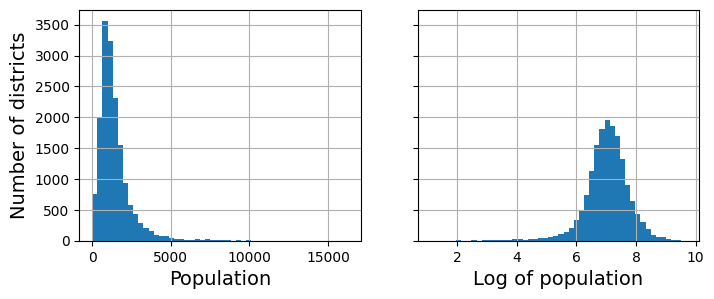

In [116]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing_train["population"].hist(ax=axs[0], bins=50)
housing_train["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
#save_fig("long_tail_plot")
plt.show()
# DISTRIBUCIONES: gausiana (la que mas usamos), LONG TAIL, EXPONENCIAL (forma de codo, menos a más)

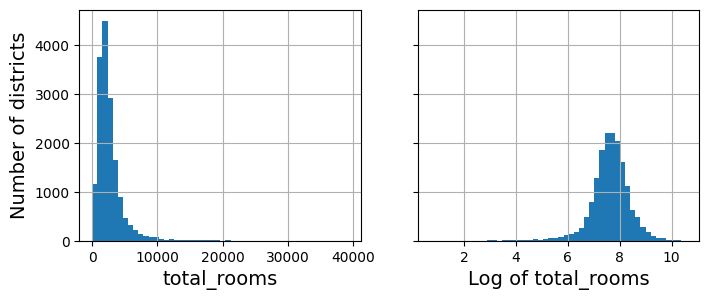

In [117]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing_train["total_rooms"].hist(ax=axs[0], bins=50)
housing_train["total_rooms"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("total_rooms")
axs[1].set_xlabel("Log of total_rooms")
axs[0].set_ylabel("Number of districts")
#save_fig("long_tail_plot")
plt.show()

## Ahora que ya sabemos lo que queremos... no estamos locos (en fin... GABRIELA, NO GRABES ESTO), y podemos hacer nuestra lista de preprocesados...

1. Imputer
2. OneHotEncoding
3. Añadido Características (los ratios)
4. Escalado
5. Transformado distribuciones


### Creando transformers sencillos

In [118]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing_train[["population"]])

In [119]:
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

### Creando nuestros pipelines

In [120]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

In [121]:
num_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('standardize', StandardScaler())])

In [122]:
from sklearn.pipeline import make_pipeline

In [123]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households"]
cat_attribs = ["ocean_proximity","income_cat"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", sparse_output=False))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

In [130]:
preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardize',
                                                  StandardScaler())]),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['ocean_proximity', 'income_cat'])])

In [124]:
housing_final_train = strat_train_set.drop(["NBA","new_district_id"], axis = 1)

In [125]:
test_housing_train = preprocessing.fit_transform(housing_final_train)

In [131]:
preprocessing.named_transformers_

{'num': Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                 ('standardize', StandardScaler())]),
 'cat': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                 ('onehotencoder',
                  OneHotEncoder(handle_unknown='ignore', sparse_output=False))]),
 'remainder': 'drop'}

In [126]:
preprocessing.get_feature_names_out()

array(['num__longitude', 'num__latitude', 'num__housing_median_age',
       'num__total_rooms', 'num__total_bedrooms', 'num__population',
       'num__households', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'cat__income_cat_1', 'cat__income_cat_2', 'cat__income_cat_3',
       'cat__income_cat_4', 'cat__income_cat_5'], dtype=object)

In [127]:
test_housing_train.shape

(16512, 17)

In [128]:
housing_train.head(8)

housing_median_age  total_rooms  total_bedrooms  population  \
13096                52.0       3321.0          1115.0      1576.0   
14973                40.0       1965.0           354.0       666.0   
3785                 33.0       1083.0           217.0       562.0   
14689                17.0       4174.0           851.0      1845.0   
20507                36.0       4366.0          1211.0      1912.0   
1286                 52.0       1829.0           301.0       694.0   
18078                34.0       1086.0           197.0       509.0   
4396                 36.0       4787.0           900.0      2039.0   

       households ocean_proximity  income_cat  longitude  latitude  \
13096      1034.0        NEAR BAY           2    -122.42     37.80   
14973       357.0       <1H OCEAN           5    -118.38     34.14   
3785        203.0          INLAND           2    -121.98     38.36   
14689       780.0          INLAND           2    -117.11     33.75   
20507      1172.0      NEAR OCEAN           3    -118.15     33.77   
1286        319.0          INLAND           3    -121.31     37.96   
18078       158.0       <1H OCEAN           5    -118.36     33.85   
4396        890.0        NEAR BAY           4    -122.13     37.41   

                              new_district_id  
13096  0-b8dea43d-5d6f-4e49-b71d-e2f10e5a5109  
14973  0-5091dafa-2699-4bec-acfc-2fc0f13a47e0  
3785   0-570ebd94-e8ee-4ceb-9663-cda7e0c1a599  
14689  0-f21fbe68-4cbc-490e-a410-9933e1ef9832  
20507  0-c93a9901-ad61-4a67-8ce0-6617196e5061  
1286   0-d7f1a77a-9cae-44e4-924f-40946f184db8  
18078  0-0e885660-b409-402a-99f4-1de6b41d94ea  
4396   0-96ad9198-9d95-41f3-8b1a-a67e15b6f0d0

In [129]:
type(test_housing_train)

numpy.ndarray

In [132]:
housing_prepared_fr = pd.DataFrame(
    test_housing_train,
    columns=preprocessing.get_feature_names_out())

In [133]:
housing_prepared_fr.head(8)

num__longitude  num__latitude  num__housing_median_age  num__total_rooms  \
0       -1.423037       1.013606                 1.861119          0.311912   
1        0.596394      -0.702103                 0.907630         -0.308620   
2       -1.203098       1.276119                 0.351428         -0.712240   
3        1.231216      -0.884924                -0.919891          0.702262   
4        0.711362      -0.875549                 0.589800          0.790125   
5       -0.868193       1.088610                 1.861119         -0.370856   
6        0.606392      -0.838047                 0.430885         -0.710868   
7       -1.278077       0.830784                 0.589800          0.982782   

   num__total_bedrooms  num__population  num__households  \
0             1.368167         0.137460         1.394812   
1            -0.435925        -0.693771        -0.373485   
2            -0.760709        -0.788768        -0.775727   
3             0.742306         0.383175         0.731375   
4             1.595753         0.444376         1.755263   
5            -0.561571        -0.668194        -0.472739   
6            -0.808122        -0.837181        -0.893265   
7             0.858470         0.560383         1.018690   

   cat__ocean_proximity_<1H OCEAN  cat__ocean_proximity_INLAND  \
0                             0.0                          0.0   
1                             1.0                          0.0   
2                             0.0                          1.0   
3                             0.0                          1.0   
4                             0.0                          0.0   
5                             0.0                          1.0   
6                             1.0                          0.0   
7                             0.0                          0.0   

   cat__ocean_proximity_ISLAND  cat__ocean_proximity_NEAR BAY  \
0                          0.0                            1.0   
1                          0.0                            0.0   
2                          0.0                            0.0   
3                          0.0                            0.0   
4                          0.0                            0.0   
5                          0.0                            0.0   
6                          0.0                            0.0   
7                          0.0                            1.0   

   cat__ocean_proximity_NEAR OCEAN  cat__income_cat_1  cat__income_cat_2  \
0                              0.0                0.0                1.0   
1                              0.0                0.0                0.0   
2                              0.0                0.0                1.0   
3                              0.0                0.0                1.0   
4                              1.0                0.0                0.0   
5                              0.0                0.0                0.0   
6                              0.0                0.0                0.0   
7                              0.0                0.0                0.0   

   cat__income_cat_3  cat__income_cat_4  cat__income_cat_5  
0                0.0                0.0                0.0  
1                0.0                0.0                1.0  
2                0.0                0.0                0.0  
3                0.0                0.0                0.0  
4                1.0                0.0                0.0  
5                1.0                0.0                0.0  
6                0.0                0.0                1.0  
7                0.0                1.0                0.0

In [134]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households"]),
        ("cat", cat_pipeline, cat_attribs),
    ],
    remainder=default_num_pipeline)  

In [135]:
prepared_housing_train = preprocessing.fit_transform(housing_final_train)

In [136]:
prepared_housing_train.shape

(16512, 21)

In [137]:
print("\n".join(list(preprocessing.get_feature_names_out())))

bedrooms__ratio
rooms_per_house__ratio
people_per_house__ratio
log__total_bedrooms
log__total_rooms
log__population
log__households
cat__ocean_proximity_<1H OCEAN
cat__ocean_proximity_INLAND
cat__ocean_proximity_ISLAND
cat__ocean_proximity_NEAR BAY
cat__ocean_proximity_NEAR OCEAN
cat__income_cat_1
cat__income_cat_2
cat__income_cat_3
cat__income_cat_4
cat__income_cat_5
remainder__housing_median_age
remainder__median_house_value
remainder__longitude
remainder__latitude


# Y ahora sí, a cocinar modelos: Selección y entrenamiento

<img src="./img/ml_pipeline_6.png" alt="drawing" width="700"/>

<img src="./img/model_review.png" alt="drawing" width="700"/>


## Decidir qué modelos
Existen una gran cantidad de modelos que nos solventarán problemas de todo tipo. Ahora bien, ¿qué modelo se adapta mejor a los datos? Va a depender de los siguientes factores:

#### Volumen de datos
Lo ideal es cuantos más datos mejor, pero si tenemos:
1. **Pocos datos y muchas features**: elige algoritmos con alto bias y low variance. Algoritmos que tienen algo más de error, pero generalizan mejor. Lienar regression, naive bayes, Linear SVM
2. **Muchos datos y pocas features**: elige algoritmos con low bias y high variance: KNN, Decission trees, resto de kernels de SVM

#### Accuracy vs interpretability
Lo más importante a la hora de elegir modelo. ¿Cuánto de explicable tiene que ser mi modelo? Si tenemos que dar una justificación detallada de las decisiones que toma mi modelo, necesitaré un algoritmo de caja blanca, de lo contrario, será un caja negra. Normalmente los algoritmos caja negra tienen una mejor precisión. El problema que presentan es que resulta muy difícil seguir la traza de los outputs del modelo y no sabemos muy bien qué está haciendo.

<img src="./img/choose_algorithm.png" alt="drawing" width="450"/>


#### Velocidad de entrenamiento
Normalmente los algoritmos más precisos suelen tener un tiempo de entrenamiento alto.
1. Rápidos: Logistic regression, linear models, naive bayes.
2. Lentos: SVM (por el tunning de hiperparámetros), RRNN, ensembles.

#### Relaciones lineales entre los datos
La importancia del análisis exploratorio. Si la relacion con el target es lineal, va a predecir bien un modelo lineal como logistic regression o SVM lineal. Si no tendremos que acudir a otros modelos que permitan modelar relaciones no lineales, como por ejemplo random forest, KNN, kernel SVM o redes neuronales.

¿Cómo comprobamos esto? Mediante el análisis exploratorio. Aunque otra opción sería entrenar una regresión lineal y analizar la aleatoriedad de los residuos. Deberían caer en una nube alrededor del 0, sin patrones tipo una parábola.

<img src="./img/choose_algorithm2.png" alt="drawing" width="650"/>

# Para nuestro ejemplo
  ### _1. Estimar el valor/precio de las casas en un distrito -> Regresion, 16000 muestras -> LinearRegression, Decission Tree, RandomForest, GBT?_
  ### _2. Estimar el deporte favorito por distrito -> Clasificación 16000 muestras -> GBT, DecissionTree, Logistic Regression_



Nota: ¿Pensáis que falta algo? Lo veremos al final del todo

In [138]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier


Seleccionamos el modelo mejor para cada problema, ¿pero qué metricas?

¿Cómo compararemos? ¿Entrenamos con todos los datos y comparamos la predicción con el test dataset? ¿Por qué no? ¿Hacemos lo mismo pero con el dataset de Train? ¿Por qué no o por qué sí?

In [139]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, precision_recall_curve, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, accuracy_score

## Predicción de precios

Regresos Lineal (sin optimizar hiperparámetros)

In [144]:
housing_final_train.drop(columns='median_house_value', inplace=True)

KeyError: "['median_house_value'] not found in axis"

In [ ]:
lin_reg = make_pipeline(preprocessing, LinearRegression()) #modelo instanciado(con paréntesis)
lin_reg.fit(housing_final_train, y_train_value)
housing_predictions = lin_reg.predict(housing_final_train)
lin_rmse = mean_squared_error(y_train_value, housing_predictions,
                              squared=False)
lin_rmse #error en $

c:\Users\pabma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


68973.64382450891

In [ ]:
# ¿Cómo se estructura lin_reg?
# ¿Qué te parece el error?

In [146]:
list_models_names = ["Regresor Lineal","Arbol de Decision","Random Forest"]
list_models = [LinearRegression, DecisionTreeRegressor, RandomForestRegressor]
regression_models = {model_name:make_pipeline(preprocessing,model()) for model_name,model in \
                 zip(list_models_names, list_models)}

In [147]:
results = {}
best_name = "None"
best = None
for model_name,modelo in regression_models.items():
    t_zero = tm.time()
    modelo.fit(housing_final_train,y_train_value)
    housing_predictions = modelo.predict(housing_final_train)
    results[model_name] = mean_squared_error(y_train_value, housing_predictions,
                              squared=False)
    best = results[model_name] if best == None else best
    best_name = model_name if results[model_name] < best else best_name
    best = results[model_name] if results[model_name] < best else best
    print("Modelo <{}> -> RSME: {}, training_time: {}".format(model_name, results[model_name], tm.time() - t_zero))
print("Best: ",best_name)


c:\Users\pabma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Modelo <Regresor Lineal> -> RSME: 68973.64382450891, training_time: 0.06383824348449707


c:\Users\pabma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Modelo <Arbol de Decision> -> RSME: 0.0, training_time: 0.2590816020965576
Modelo <Random Forest> -> RSME: 18652.564705336503, training_time: 13.36527967453003
Best:  Arbol de Decision


c:\Users\pabma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


El mejor es un Overfitter...

Mejor si probamos con una validación cruzada

In [148]:
from sklearn.model_selection import cross_val_predict, cross_val_score
#predict dice predicción de la cv
#score dice 
# SOLO SIRVE PARA VER CUÁL FUNCIONA MEJOR, PERO NO ENRENAN EL MODELO. HAY QUE HACERLE FIT.

In [149]:
resultados = {}
for model_name, model in regression_models.items():
    t_zero = tm.time()
    model_rmses = -cross_val_score(model, housing_final_train, y_train_value,
                              scoring="neg_root_mean_squared_error", cv=10)
    resultados[model_name] = pd.Series(model_rmses).mean()
    print(model_name)
    print(pd.Series(model_rmses).describe())
    print("Validation time: ", tm.time() - t_zero)
    print("#######\n")

Regresor Lineal
count       10.000000
mean     69753.461603
std       2799.114260
min      66936.166363
25%      68464.624624
50%      68785.422607
75%      70197.828566
max      76887.643835
dtype: float64
Validation time:  0.4917576313018799
#######

Arbol de Decision
count       10.000000
mean     69972.152315
std       1540.860317
min      67866.242368
25%      68646.112335
50%      70123.509285
75%      71238.100297
max      71891.298835
dtype: float64
Validation time:  2.1682114601135254
#######

Random Forest
count       10.000000
mean     50585.631761
std        792.984754
min      49281.860565
25%      50222.531610
50%      50680.629753
75%      51165.876450
max      51615.940444
dtype: float64
Validation time:  120.04427599906921
#######



... and the "oscar" goes to ... 

### Antes de pasar a Clasificación, hay dos modelos que hacen overfitting, qué podemos hacer: Regularizar


## Predicción de deporte favorito

In [150]:
from sklearn.metrics import ConfusionMatrixDisplay

In [151]:
list_models_names = ["Regresion Logistica","Arbol de Decision","Random Forest", "GBT"]
list_models = [LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier]
classification_models = { model_name:make_pipeline(preprocessing,model() if "Regresion" not in model_name else model(max_iter = 1000)) for model_name,model in \
                 zip(list_models_names, list_models)}

Regresion Logistica
Precision: 0.71
Recall: 0.68
Accuracy: 0.70
f1_score: 0.69
Training time: 0.92

#######

Arbol de Decision
Precision: 0.66
Recall: 0.65
Accuracy: 0.65
f1_score: 0.65
Training time: 2.50

#######

Random Forest
Precision: 0.75
Recall: 0.68
Accuracy: 0.73
f1_score: 0.72
Training time: 28.54

#######

GBT
Precision: 0.77
Recall: 0.67
Accuracy: 0.73
f1_score: 0.72
Training time: 36.68

#######



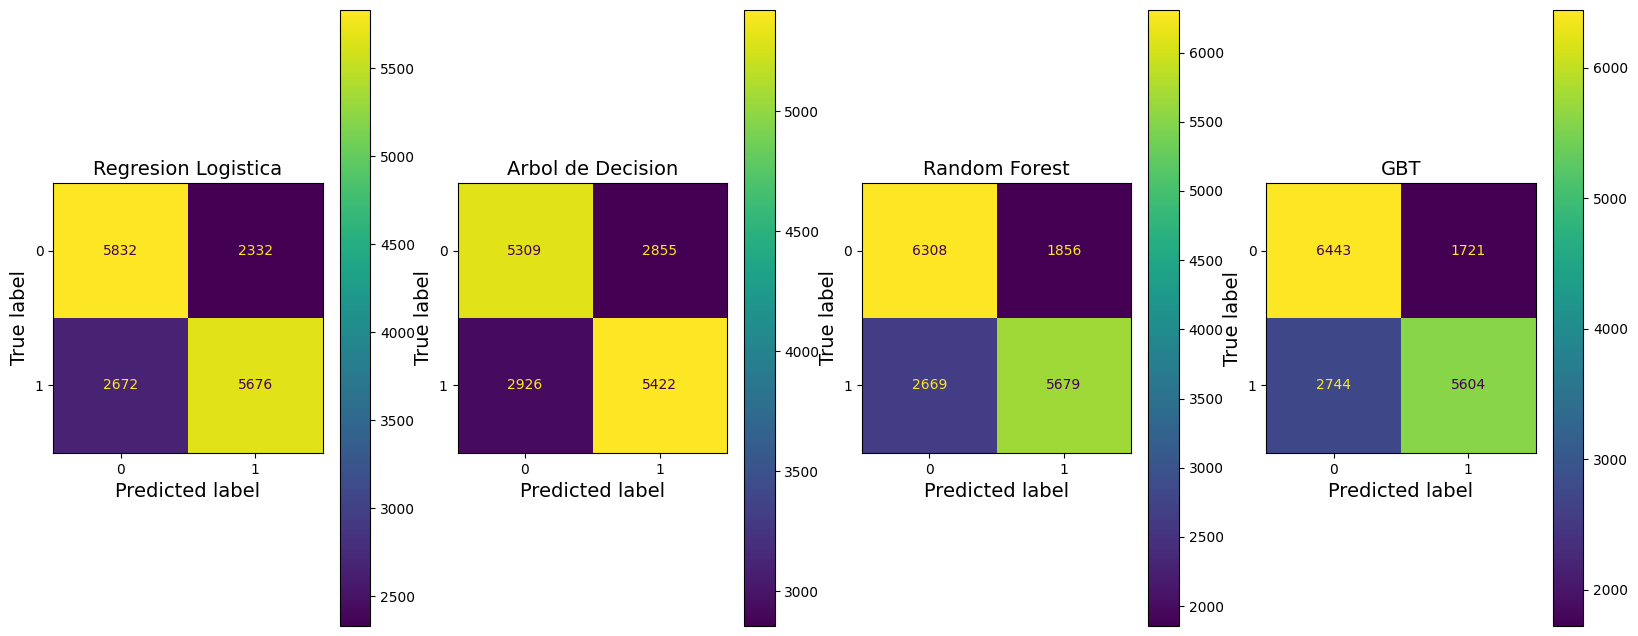

In [152]:
results = {}
best_name = "None"
best = None
indice = 0
fig, axs = plt.subplots(nrows=1, ncols=len(classification_models), figsize=(20, 8))
num_cv = 10
#for model_name,modelo in [(clave, valor) for clave,valor in classification_models.items() if "Logist" not in clave]:
for model_name,modelo in classification_models.items():
    t_zero = tm.time()
    print(model_name)
    results[model_name] = {}
    modelo.fit(housing_final_train,y_train_NBA)
    if num_cv < 2:
        housing_predictions = modelo.predict(housing_final_train)
        
    else:
        housing_predictions = cross_val_predict(modelo,housing_final_train, y_train_NBA, cv = num_cv, \
                                                method = "predict")
    # Metrics
    results[model_name]["predictions"] = housing_predictions.copy()
    for metric,evaluator in zip(["Precision","Recall","Accuracy","f1_score"],[precision_score, recall_score, \
                                                                              accuracy_score, f1_score]):
        results[model_name][metric] = evaluator(y_train_NBA,housing_predictions)
        print("%s: %.2f" %(metric, results[model_name][metric]))
    plt.rc('font', size=10)
    ConfusionMatrixDisplay.from_predictions(y_train_NBA, housing_predictions, ax=axs[indice]) 
    axs[indice].set_title(model_name)
    #results[model_name] = recall_score(y_train_NBA, housing_predictions)
    #print(results[model_name])
    #best = results[model_name] if best == None else best
    #best_name = model_name if results[model_name] < best else best_name
    #best = results[model_name] if results[model_name] > best else best
    #print("Modelo <{}> -> Precision: {}, training_time: {}".format(model_name, results[model_name], tm.time() - t_zero))
    print("Training time: %.2f\n" %(tm.time() - t_zero))
    print("#######\n")
    indice += 1
#print("Best: ",best_name)
plt.show()

### Recordando un poco de las metricas de clasificación

### Métricas para clasificación

##### Accuracy
La métrica más habitual. Calcula el % de acierto teniendo en cuenta todas las clases del algoritmo de clasificación. Esta métrica es muy fácil de entender, pero no profundiza en el % de acierto de cada clase, que puede ser algo interesante, dependiendo del problema que queramos tratar.

Accuracy = (TP + TN) / Total

##### Matriz de confusión
Confusión o *error matrix* es una tabla que describe el rendimiento de un modelo supervisado de Machine Learning en los datos de test, donde se desconocen los verdaderos valores. Se llama “matriz de confusión” porque hace que sea fácil detectar dónde el sistema está confundiendo dos clases.

* **True Positives (TP)**: cuando la clase real del punto de datos era 1 (Verdadero) y la predicha es también 1 (Verdadero)
* **Verdaderos Negativos (TN)**: cuando la clase real del punto de datos fue 0 (Falso) y el pronosticado también es 0 (Falso).
* **False Positives (FP)**: cuando la clase real del punto de datos era 0 (False) y el pronosticado es 1 (True).
* **False Negatives (FN)**: Cuando la clase real del punto de datos era 1 (Verdadero) y el valor predicho es 0 (Falso).

##### Recall o Sensibilidad
Los positivos que he clasificado bien vs todos los positivos que había. Métrica que se utiliza cuando queremos ahcer foco en minimizar los FN (Falsos Negativos). Claro ejemplo puede ser un test de COVID. No me importa tanto que haya FP, ya que las consecuencias son aislamientos preventivos, mientras que tener FN, es decir, personas con COVID, cuyo resultado del test es negativo, si es grave ya que pueden producir más contagios.

Recall = TP / (TP + FN)

##### Precision
De los que ha predicho como 1, cuántos en realidad ha acertado. Precision, a diferencia del recall, pone foco en minimizar los FP. Como ejemplo podemos poner un filtro anti-spam. Que se cuele algún correo de spam (FN) no me importa. Ahora bien, si se clasifica como spam un correo importante del jefe (FP) y no lo leemos, sí es más grave.

Precision = TP / (TP + FP)

##### Specifity
Es el número de ítems correctamente identificados como negativos sobre el total de negativos. Es lo opuesto al Recall.

Specifity = TN / (TN + FP)

##### F1-Score
Combinación de las métricas Precision y Recall. Esta métrica se utiliza para comparar clasificadores, ya que es algo más compleja de entender, pero muy útil cuando tenemos clasificadores cuyos valores de recall y precision se intercalan unos con otros y no está muy claro cuál es mejor, a no ser que tengamos claro que hay que centrarse o bien en el recall o en el precision. El rango del F1-score va de 0 a 1, como las métricas anteriores.

F1-score = 2 * Precision * Recall / (Precision + Recall)


##### Precision vs Recall plot
Recuerda que el modelo por defecto calcula las probabilidades de pertenecer a una clase, y que por defecto, si por ejemplo el clasificador es binario, y la probabilidad cae por encima del 50% se clasificaría como 1, como positivo. Ahora bien, modificar ese threshold cambia completamente la matrz de confusión. Si subimos el threshold somos más restrictivos con los 1s, y por tanto empezará a clasificar más valores como 0s y como FN. En cambio si lo bajamos, somos más permisivos con los 1s, los clasificaríamos casi todos, pero subirían los FP.

Es por ello que existen curvas como ROC o Precision vs Recall con las que podremos ver diferentes comportamientos del clasificador, teniendo en cuenta varios thresholds, y todo ello en una misma gráfica.

Mediante esta curva obtendremos el punto óptimo de precision vs recall. Para usar esta gráfica hay que comprender bien qué significan las métricas de precision y de recall

<img src="./img/precs_recall.png" alt="drawing" width="500"/>

##### ROC Curve/AUC
Similar a la anterior curva. Nos sirve para comparar el recall con FPR = FP/(FP + TN)

De esta curva podemos obtener una medida, que es el AUC (Area Under the Curve). El AUC cuanto más cercano a 1, mejor será el clasificador. Si la curva es una línea recta estaremos ante un clasificador muy malo, que no sería muy diferente a un clasificador aleatorio.

**Normalmente se usa la ROC curve cuando tenemos datasets balanceados, mientras que la curva precision-recall es más propia de datasets con una clase mayoritaria.**


Si tenemos dudas, podemos pintar las curvas ROC

In [153]:
from sklearn.metrics import roc_curve, auc
import matplotlib.patches as patches
import matplotlib.pyplot as plt

Regresion Logistica
AUROC: 0.76
Random Forest
AUROC: 0.80
GBT
AUROC: 0.79


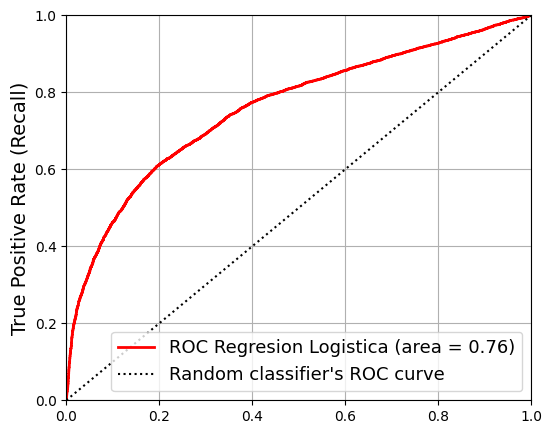

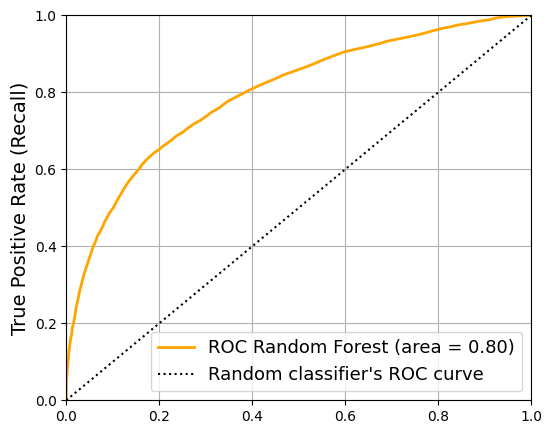

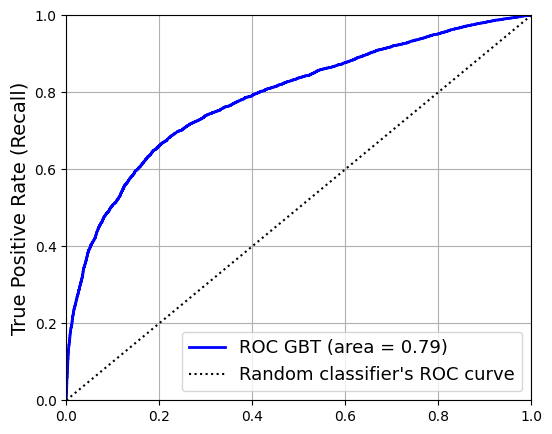

In [154]:
colores = ["red","orange","blue","maroon"]
indice = 0
for model_name,modelo in [(model_name, modelo) for model_name,modelo in classification_models.items() if "Arbol" not in model_name]:
    print(model_name)
    scores = cross_val_predict(modelo,housing_final_train,y_train_NBA, cv = num_cv, method = "predict_proba")
    fpr, tpr, thresholds = roc_curve(y_train_NBA, scores[:,1])
    #idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
    #tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]
    roc_auc = auc(fpr,tpr)
    print("AUROC: %.2f" %(roc_auc))
    plt.figure(figsize=(6, 5))  
    plt.plot(fpr, tpr, linewidth=2, color= colores[indice], label="ROC %s (area = %0.2f)" %(model_name, roc_auc))
    plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
#plt.xlabel('False Positive Rate (Fall-Out)')
    plt.ylabel('True Positive Rate (Recall)')
    plt.grid()
    plt.axis([0, 1, 0, 1])
    plt.legend(loc="lower right", fontsize=13)
    #plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

    # extra code – just beautifies and saves Figure 3–7
    #plt.gca().add_patch(patches.FancyArrowPatch(
        #(0.20, 0.89), (0.07, 0.70),
        #connectionstyle="arc3,rad=.4",
        #arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
        #color="#444444"))
    #plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
    indice += 1
plt.show()



Por esta vez nos quedamos con GBT (por cambiar), pero igual habría que optimizar los parámetros de los tres y luego volver a validarlos

<img src="./img/ml_pipeline_7.png" alt="drawing" width="700"/>

## "Tunear" el modelo: Elegir hiperparámetros

<img src="./img/estilos_tuning.jpg" alt="drawing" width="700"/>

Como ya sabes, cada dataset es de su padre y de su madre, y por tanto es imposible determinar el modelo con sus hiperparámetros que mejor se ajusten a los datos. Por tanto, tendremos que probar varias combinaciones. Por suerte `sklearn` tiene una función llamada GridSearchCV que permite probar varias combinaciones de una manera automatizada.

Empieza iterando unos pocos hiperparámetros y luego ve subiendo, según los resultados de esa ejecución.



Nota:  
* Parámetros (pesos), los que ajusta internamente cada modelo según su filosofía de "aprendizaje"  
* Hiperparámetros: Los que podemos "tocar" desde fuera y que suelen tener que ver con la estructura del modelo, el nivel de aprendizaje, numero de iteraciones para aprender, etc... Para esto tengo que saber qué hace el modelo para poder tocar y bichear (cómo lo configuro, qué le tengo que meter y qué me va a dar de salida).  

**Observación**: Todos los modelos que estamos viendo son herramientas, es ir cogiendo experiencia con ellos. 

## Grid_search

In [155]:
from sklearn.model_selection import GridSearchCV

In [156]:
## Estos son los hiperparámetros básicos que tenemos que saber, hay más (obviamente). Iremos viendo otros
# RANDOM FOREST
## filosofía de sklearn - más más (cuantos más parámetros y más valores en estos, más overfitting)
grid_random_forest = {"randomforestregressor__n_estimators": [100,120], # El Random Forest no suele empeorar por exceso de
                                             # estimadores. A partir de cierto numero no merece la pena
                                             # perder el tiempo ya que no mejora mucho más la precisión.
                                             # Entre 100 y 200 es una buena cifra

                     
                     "randomforestregressor__max_depth": [3,4,5], # No le afecta tanto el overfitting como al decissiontree.
                                                      # Podemos probar mayores profundidades
                      
                     "randomforestregressor__max_features": [3, 4, 6] # Numero de features que utiliza en cada split.
                                                    # cuanto más bajo, mejor generalizará y menos overfitting.
                                                      #se pude poner sqrt del nº de features
                                                    
                     }


# GRADIENT BOOSTING (secuenciales)
grid_gradient_boosting = {"gradientboostingclassifier__loss": ["log_loss"], # Deviance suele ir mejor.
                          "gradientboostingclassifier__learning_rate": [0.05, 0.1, 0.2, 0.4],  # Cuanto más alto, mas aporta cada nuevo arbol
                          
                          "gradientboostingclassifier__n_estimators": [20,50,100], # Cuidado con poner muchos estiamdores ya que vamos a
                                                           # sobreajustar el modelo
                          
                          "gradientboostingclassifier__max_depth": [1,2,3,4], # No es necesario poner una profundiad muy alta. Cada nuevo
                                                    # arbol va corrigiendo el error de los anteriores.
                          
                          
                          "gradientboostingclassifier__max_features": [3, 4], # Igual que en el random forest
                          }



In [157]:
rgs_model = regression_models["Random Forest"] #recuperando los modelos dentro del dict que hicimos dentro del pipeline
clf_model = classification_models["GBT"]

In [158]:
clf_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['total_bedrooms',
                                                   'total_rooms', 'population',
                                                   'households']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['ocean_proximity',
                                                   'income_cat'])])),
                ('gradientboostingclassifier', GradientBoostingClassifier())])

In [159]:
grid_search_rgs = GridSearchCV(rgs_model, grid_random_forest, cv=3,
                           scoring='neg_root_mean_squared_error')

In [160]:
grid_search_clf = GridSearchCV(clf_model, grid_gradient_boosting, cv = 3,
                              scoring = "precision")

In [168]:
time grid_search_rgs.fit(housing_final_train, y_train_value)

CPU times: total: 36.2 s
Wall time: 36.2 s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_ou...
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['ocean_proximity',
                                                                          'income_cat'])])),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             param_grid={'randomforestregressor__max_depth': [3, 4, 5],
                         'randomforestregressor__max_features': [3, 4, 6],
                         'randomforestregressor__n_estimators': [100, 120]},
             scoring='neg_root_mean_squared_error')

In [169]:
grid_search_rgs.best_params_

{'randomforestregressor__max_depth': 5,
 'randomforestregressor__max_features': 6,
 'randomforestregressor__n_estimators': 120}

In [170]:
best_rgs = grid_search_rgs.best_estimator_ #guardo mejor modelo

In [161]:
time grid_search_clf.fit(housing_final_train, y_train_NBA)

CPU times: total: 1min 26s
Wall time: 1min 26s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_ou...
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             param_grid={'gradientboostingclassifier__learning_rate': [0.05,
                                                                       0.1, 0.2,
                                                                       0.4],
                         'gradientboostingclassifier__loss': ['log_loss'],
                         'gradientboostingclassifier__max_depth': [1, 2, 3, 4],
                         'gradientboostingclassifier__max_features': [3, 4],
                         'gradientboostingclassifier__n_estimators': [20, 50,
                                                                      100]},
             scoring='precision')

In [162]:
grid_search_clf.best_params_

{'gradientboostingclassifier__learning_rate': 0.2,
 'gradientboostingclassifier__loss': 'log_loss',
 'gradientboostingclassifier__max_depth': 4,
 'gradientboostingclassifier__max_features': 4,
 'gradientboostingclassifier__n_estimators': 100}

In [163]:
best_clf = grid_search_clf.best_estimator_ #guardo mejor modelo

## Evaluamos en el test set 
Para hacerme una idea de cómo funciona el modelo. No para elegir entre todos, eso ya lo he hecho en los pasos anteriores con el Cross Validation.

In [164]:
housing_test_pre = strat_test_set.drop(["NBA","median_house_value","new_district_id"], axis = 1)

In [171]:
final_predictions = best_rgs.predict(housing_test_pre)

final_rmse = mean_squared_error(y_test_value, final_predictions, squared=False)
print(final_rmse)

67672.69619575268


c:\Users\pabma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [172]:
final_predictions_clf = best_clf.predict(housing_test_pre)

for metric,evaluator in zip(["Precision","Recall","Accuracy","f1_score"],[precision_score, recall_score, \
                                                                              accuracy_score, f1_score]):
        valor = evaluator(y_test_NBA,final_predictions_clf)
        print("%s: %.2f" %(metric, valor))

Precision: 0.78
Recall: 0.66
Accuracy: 0.73
f1_score: 0.71


<img src="./img/ml_pipeline_8.png" alt="drawing" width="700"/>

# Guardamos los modelos

Dos formas, el "jefe" Aurelien nos dice que joblib es más eficiente

In [ ]:
import joblib

joblib.dump(best_rgs, "price_housing_model.pkl")

['price_housing_model.pkl']

In [ ]:
import pickle

with open('sports_housing_based_model.pkl', "wb") as archivo_salida:
    pickle.dump(best_clf, archivo_salida)
    #se guarda el modelo con los pipelines (definición de las tuberías)
    #del modelo guarda los parámetros y los hiperparámetros

## Despliegue en producción (bueno...)

In [ ]:
import joblib

# extra code – excluded for conciseness -> All the ETL, cleaning, etc to \
# get a housing data as the one expected by the pipelines

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

final_model_reloaded = joblib.load("price_housing_model.pkl") #cargamos el modelo

new_data = housing_test_pre.iloc[:5]  # pretend these are new districts
predictions = final_model_reloaded.predict(new_data)

In [ ]:
predictions

array([385377.73094037, 237203.34039665, 249506.43037909, 227554.60451355,
       265202.96220141])

In [ ]:
import pickle

# extra code – excluded for conciseness -> All the ETL, cleaning, etc to \
# get a housing data as the one expected by the pipelines
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]


with open('sports_housing_based_model.pkl', "rb") as archivo_salida:
    best_clf = pickle.load(archivo_salida)
    
new_data = housing_test_pre.iloc[:10]  # pretend these are new districts
predictions = best_clf.predict(new_data)

In [ ]:
predictions

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0])

## ULTIMAS CONSIDERACIONES

### _La verdadera Evaluación..._
  Se debe hacer contra los objetivos finales o de negocio y siempre preguntar o aclarar para que no estemos entrenando modelos muy predictivos de algo que nadie quiere saber


### _AUTO ML, ML FLOW, CLOUD MLs, etc_
La importancia del Data Engineering aumenta si vamos a trabajar solo con modelos "clásicos" en problemas clásicos. Por otro lado la aparición de modelos más complejos (DL) y de caja negra y la preocupación por los sesgos hace cada vez más importante el trabajo del DS en la interpretabilidad de modelos.

  
### _Deep Learning_
Para la resolución de problemas diferentes (más o menos complejos, en general más, como detección de objetos, procesado avanzado de lenguaje natural, realización de acciones autónomas), surge la necesidad de tratar con datos con una mayor dimensionaliad (o sea, muchísimas más features). El coste es doble: tiempos de ejecución y la maldición de la dimensionalidad (a mayor número de features, mayor número de posibles relaciones entre ellas, más complejo es optimizar funciones de coste, utilidad o pérdida).
Para tratar con todo ello surge Deep Learning o por lo menos así nos lo han vendido...
¿Tiene sentido aplicar DL a problemas "sencillos"? (abro hilo de debate :-)...)